In [88]:
import numpy as np
import random
import os
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [89]:
import numpy as np

# 示例数据
data = np.random.normal(loc=0, scale=1, size=(1000,))

# 提取分位数点
quantiles = np.percentile(data, [25, 50, 75])  # 提取 25%, 50%, 75%
print("Quantiles:", quantiles)


Quantiles: [-0.7162306  -0.03135474  0.59200994]


In [90]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class QuantileTransformer(nn.Module):
    def __init__(self, input_dim, d_model, num_heads, num_layers):
        super(QuantileTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=num_heads)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, d_model)  # 输出为嵌入向量
    
    def forward(self, x):
        x = self.embedding(x)  # 输入映射到 d_model 维
        x = self.transformer_encoder(x)
        return self.output_layer(x)

# 示例：处理分位数点
quantile_points = torch.tensor(quantiles, dtype=torch.float32).unsqueeze(0)  # [1, 3]
transformer = QuantileTransformer(input_dim=3, d_model=16, num_heads=2, num_layers=2)
quantile_embeddings = transformer(quantile_points)
print("Quantile Embeddings:", quantile_embeddings)
inputdata = np.random.normal(loc=0, scale=1, size=(1000, 3))  
inputdata = torch.tensor(inputdata, dtype=torch.float32).cuda()
inputdata.shape

Quantile Embeddings: tensor([[ 0.8894,  0.7536, -0.3527, -0.1772, -1.0310,  0.0537,  0.0834,  0.0528,
          0.4651, -0.1994, -0.4204,  0.8989, -0.2100,  0.2014, -0.3541, -0.0282]],
       grad_fn=<AddmmBackward0>)


C:\Users\19513\AppData\Roaming\Python\Python39\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


torch.Size([1000, 3])

<Axes: ylabel='Count'>

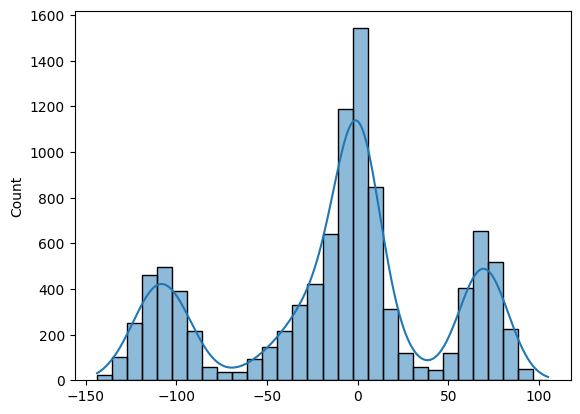

In [91]:
import numpy as np
import torch

# 生成多峰分布数据
data1 = np.random.multivariate_normal([3, 9], [[1, 0.5], [0.5, 1]], 2000)
data2 = np.random.multivariate_normal([-3, -9], [[1, 0.5], [0.5, 1]], 2000)
data3 = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], 2000)
data4 = np.random.multivariate_normal([6, -6], [[1, 0.5], [0.5, 1]], 2000)
data5 = np.random.multivariate_normal([-6, 6], [[1, 0.5], [0.5, 1]], 2000)
data6 = np.vstack([data1, data2, data3, data4, data5])

coef1 = [5, 6]
coef2 = [25, -6]
coef3 = [3, 13]
coef4 = [4, 4]
coef5 = [14, -4]
noise = np.random.randn(10000)

# 生成多峰目标变量
data7_1 = data6[:2000, 0] * coef1[0] + data6[:2000, 1] * coef1[1] + noise[:2000]
data7_2 = data6[2000:4000, 0] * coef2[0] + data6[2000:4000, 1] * coef2[1] + noise[2000:4000]
data7_3 = data6[4000:6000, 0] * coef3[0] + data6[4000:6000, 1] * coef3[1] + noise[4000:6000]
data7_4 = data6[6000:8000, 0] * coef4[0] + data6[6000:8000, 1] * coef4[1] + noise[6000:8000]
data7_5 = data6[8000:, 0] * coef5[0] + data6[8000:, 1] * coef5[1] + noise[8000:]
data7 = np.concatenate([data7_1, data7_2, data7_3, data7_4, data7_5])

# 合并数据
data = np.concatenate([data6, data7.reshape(-1, 1)], axis=1)
dataset = torch.tensor(data).float()
sns.histplot(data[:,-1], kde=True, bins=30)


In [92]:
class quantile_Backbone(nn.Module):
    def __init__(self, input_dim,output_dim):
        super().__init__()
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU()
        )
       
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, output_dim),
        )
    def forward(self, x):   
        x = self.linear_model1(x)
        x = self.linear_model2(x)
        return x
    def loss_fn(self, y_pred, y_true, alpha):
        return torch.mean(torch.max(alpha * (y_true - y_pred), (alpha - 1) * (y_true - y_pred)))



In [14]:
class con_Backbone(nn.Module):
    def __init__(self, n_steps, input_dim = 1,con_dim=4):
        super().__init__()
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim+con_dim, 32),
            nn.ReLU()
        )
        # Condition time t
        self.embedding_layer = nn.Embedding(n_steps, 32)
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(32+con_dim, 32),
            nn.ReLU(),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, input_dim),
        )
    def forward(self, x, con_x,idx):   
        x = torch.cat((x, con_x), dim=1) 
        x = torch.cat((self.linear_model1(x)+self.embedding_layer(idx),con_x),dim = 1)
        x = self.linear_model2(x)
        return x


In [15]:
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T, input_dim,con_dim,alpha_mix,iftrained=False,trainedmodel=None):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''
        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = con_Backbone(T, input_dim,con_dim)
        if iftrained:
            self.quantile_backbone = trainedmodel
        else:    
            self.quantile_backbone = quantile_Backbone(con_dim,input_dim)
        self.to(device = self.device)
        self.alpha_mix = alpha_mix  
        self.counter = 0
    def loss_fn(self, x, con_x, lambda1, alpha, idx=None, train_stage="joint"):
        '''
        Compute the loss for training.

        train_stage : "quantile" (only train quantile regression),
                    "diffusion" (only train diffusion),
                    "joint" (jointly train both).
        '''
        # 计算 quantile_output
        
        self.counter += 1
        # 根据不同的训练阶段计算损失
        quantile_output,output, epsilon, alpha_bar = self.forward(x, con_x,  idx=idx, get_target=True)

        # 计算 quantile loss
        quantile_loss = self.quantile_backbone.loss_fn(quantile_output, x, alpha)

        # 计算 diffusion loss
        ddpm_loss = (output - epsilon).square().mean()

        # 根据 train_stage 决定冻结哪一部分网络的梯度
        if train_stage == "quantile":
            # 冻结 diffusion 部分
            for param in self.backbone.parameters():
                param.requires_grad = False
            for param in self.quantile_backbone.parameters():
                param.requires_grad = True
            return lambda1 * quantile_loss

        elif train_stage == "diffusion":
            # 冻结 quantile 部分
            for param in self.quantile_backbone.parameters():
                param.requires_grad = False
            for param in self.backbone.parameters():
                param.requires_grad = True
            return ddpm_loss

        elif train_stage == "joint":
            # 两部分都更新
            for param in self.quantile_backbone.parameters():
                param.requires_grad = True
            for param in self.backbone.parameters():
                param.requires_grad = True
            
            # 在最后一次计算损失时打印 quantile_output
            return lambda1 * quantile_loss + (1-lambda1) * ddpm_loss

        else:
            raise ValueError("Invalid train_stage. Choose from ['quantile', 'diffusion', 'joint'].")


    def forward(self, x, con_x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (epsilon prediction)
        '''
        quantile_output = self.quantile_backbone(con_x)
        quantile_output_mix = self.alpha_mix*quantile_output + (1-self.alpha_mix)*x
        if idx is None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device=self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * quantile_output_mix + torch.sqrt(1 - used_alpha_bars) * epsilon
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device=self.device).long()
            x_tilde = quantile_output_mix

        output = self.backbone(x_tilde, con_x, idx)

        return (quantile_output,output, epsilon, used_alpha_bars) if get_target else output
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, shape,con_x):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        shape         : data shape
        '''

        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.shape = shape
        
        self.diffusion_fn = diffusion_fn
        self.device = device

    
    def _one_diffusion_step(self, x,con_x):
        '''
        x   : perturbated data
        '''
        for idx in reversed(range(len(self.alpha_bars))):
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            sqrt_tilde_beta = torch.sqrt((1 - self.alpha_prev_bars[idx]) / (1 - self.alpha_bars[idx]) * self.betas[idx])
            predict_epsilon = self.diffusion_fn(x,con_x, idx)
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x - self.betas[idx] / torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon)
            x = mu_theta_xt + sqrt_tilde_beta * noise
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number,con_x, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        if self.shape[0]==1:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze().reshape(-1,1)
        else:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze()
        sampling_list = []
        
        final = None
        for idx, sample in enumerate(self._one_diffusion_step(sample,con_x)):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
scatter_range = [-10, 10]
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.2
batch_size =64
def traincon_ddpm(model,optimizer,num_epochs,targetdim,lambda1,alpha,traindata_loader,valdata_loader,early_stopping):
    best_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(num_epochs):
        whole_loss = 0
        for i, batch in enumerate(traindata_loader):
            batch_size = batch.shape[0]
            if targetdim==1:
                batch = batch.cuda()
                y1 = batch[:,-1].reshape(-1,1).cuda()
                x1 = batch[:,:-1].cuda()
            else:
                batch = batch.cuda()
                y1 =  torch.Tensor(batch[:,-targetdim:]).cuda() 
                x1 = batch[:,:-targetdim].cuda()
            loss = model.loss_fn(y1,x1,lambda1,alpha)
            whole_loss+=loss
            optimizer.zero_grad()
            loss = model.loss_fn(y1,x1, lambda1=1.0, alpha=alpha, train_stage="quantile")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss = model.loss_fn(y1, x1, lambda1=0.0, alpha=alpha, train_stage="diffusion")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss = model.loss_fn(y1, x1, lambda1=0.5, alpha=alpha, train_stage="joint")
            loss.backward()
            optimizer.step()

            losses.update(loss.item())
        val_loss = 0
        with torch.no_grad():
            for val_batch in valdata_loader:
                if targetdim==1:
                    batch = val_batch.cuda()
                    y1 = batch[:,-1].reshape(-1,1).cuda()
                    x1 = batch[:,:-1].cuda()
                else:
                    batch = val_batch.cuda()
                    y1 =  torch.Tensor(batch[:,-targetdim:]).cuda() 
                    x1 = batch[:,:-targetdim].cuda()
                val_loss+=model.loss_fn(y1,x1,lambda1,alpha)
            val_loss /= len(valdata_loader)
        if (epoch) % 20 == 0:
            print('epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, whole_loss/len(traindata_loader), val_loss.item()))
        loss_new = val_loss
        if loss_new < best_loss:
            best_loss = loss_new
            early_stopping_counter = 0
            print('epoch: {}, find new best loss: Train Loss: {:.4f}'.format(epoch,best_loss))
            print('-' * 10)
        else:
            early_stopping_counter += 1
        if early_stopping_counter == early_stopping:
            print("Early stopping after {} epochs".format(epoch))
            break
    

In [20]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
X_train_5, X_temp_5 = train_test_split(data, test_size=0.2, random_state=42)
X_val_5, X_test_5 = train_test_split(X_temp_5, test_size=0.5, random_state=42)

X_train_5 = pd.DataFrame(X_train_5)
X_test_5 = pd.DataFrame(X_test_5)
X_val_5 = pd.DataFrame(X_val_5)
condim = X_train_5.shape[1]-1
train_data = X_train_5
val_data = X_val_5
test_data = X_test_5
X_train_5 = np.array(train_data, dtype=np.float32)
X_val_5 = np.array(val_data, dtype=np.float32)
X_test_5 = np.array(test_data, dtype=np.float32)
resultdata = pd.DataFrame()
# 设置 'Weekly_Sales' 列的值为 vaedata 中的 'Weekly_Sales' 列的值
resultdata['test'] = X_test_5[:,-1]
scatrain5 = StandardScaler()
sca_X_train_5 = scatrain5.fit_transform(X_train_5)
scaval5 = StandardScaler()
sca_X_val_5 = scaval5.fit_transform(X_val_5)
scay5 = StandardScaler()
sca_Y_train_5 = scay5.fit_transform(X_train_5[:,-1].reshape(-1,1))
scatest5 = StandardScaler()
sca_X_test_5 = scatest5.fit_transform(X_test_5)
sca_traindata_loader_5 = DataLoader(sca_X_train_5, batch_size=64, shuffle=True)
sca_valdata_loader_5 = DataLoader(sca_X_val_5, batch_size=64, shuffle=True)
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
batch_size =64
beta_1 = 1e-4
beta_T = 0.02
T = 50
device = torch.device('cuda')


0.1
epoch: 0, Train Loss: 0.4976, Val Loss: 0.3379
epoch: 0, find new best loss: Train Loss: 0.3379
----------
epoch: 1, find new best loss: Train Loss: 0.2058
----------
epoch: 2, find new best loss: Train Loss: 0.1897
----------
epoch: 3, find new best loss: Train Loss: 0.1748
----------
epoch: 4, find new best loss: Train Loss: 0.1448
----------
epoch: 6, find new best loss: Train Loss: 0.1396
----------
epoch: 7, find new best loss: Train Loss: 0.1341
----------
epoch: 9, find new best loss: Train Loss: 0.1148
----------
epoch: 12, find new best loss: Train Loss: 0.1147
----------
epoch: 13, find new best loss: Train Loss: 0.1073
----------
epoch: 15, find new best loss: Train Loss: 0.1063
----------
epoch: 17, find new best loss: Train Loss: 0.0981
----------
epoch: 19, find new best loss: Train Loss: 0.0923
----------
epoch: 20, Train Loss: 0.0945, Val Loss: 0.0828
epoch: 20, find new best loss: Train Loss: 0.0828
----------
epoch: 24, find new best loss: Train Loss: 0.0820
-----

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.5081, Val Loss: 0.3839
epoch: 0, find new best loss: Train Loss: 0.3839
----------
epoch: 1, find new best loss: Train Loss: 0.1692
----------
epoch: 2, find new best loss: Train Loss: 0.1469
----------
epoch: 3, find new best loss: Train Loss: 0.1396
----------
epoch: 4, find new best loss: Train Loss: 0.1214
----------
epoch: 6, find new best loss: Train Loss: 0.1069
----------
epoch: 7, find new best loss: Train Loss: 0.0995
----------
epoch: 13, find new best loss: Train Loss: 0.0919
----------
epoch: 14, find new best loss: Train Loss: 0.0910
----------
epoch: 18, find new best loss: Train Loss: 0.0833
----------
epoch: 19, find new best loss: Train Loss: 0.0794
----------
epoch: 20, Train Loss: 0.0873, Val Loss: 0.0865
epoch: 21, find new best loss: Train Loss: 0.0791
----------
epoch: 25, find new best loss: Train Loss: 0.0677
----------
epoch: 27, find new best loss: Train Loss: 0.0660
----------
epoch: 32, find new best loss: Train Loss: 0.0657
--------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.4868, Val Loss: 0.3405
epoch: 0, find new best loss: Train Loss: 0.3405
----------
epoch: 1, find new best loss: Train Loss: 0.1898
----------
epoch: 2, find new best loss: Train Loss: 0.1643
----------
epoch: 3, find new best loss: Train Loss: 0.1423
----------
epoch: 6, find new best loss: Train Loss: 0.1346
----------
epoch: 7, find new best loss: Train Loss: 0.1306
----------
epoch: 8, find new best loss: Train Loss: 0.1113
----------
epoch: 13, find new best loss: Train Loss: 0.1056
----------
epoch: 15, find new best loss: Train Loss: 0.1008
----------
epoch: 16, find new best loss: Train Loss: 0.0961
----------
epoch: 17, find new best loss: Train Loss: 0.0876
----------
epoch: 19, find new best loss: Train Loss: 0.0846
----------
epoch: 20, Train Loss: 0.0878, Val Loss: 0.0728
epoch: 20, find new best loss: Train Loss: 0.0728
----------
epoch: 23, find new best loss: Train Loss: 0.0708
----------
epoch: 25, find new best loss: Train Loss: 0.0615
--------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.5004, Val Loss: 0.3735
epoch: 0, find new best loss: Train Loss: 0.3735
----------
epoch: 1, find new best loss: Train Loss: 0.1758
----------
epoch: 2, find new best loss: Train Loss: 0.1510
----------
epoch: 3, find new best loss: Train Loss: 0.1488
----------
epoch: 4, find new best loss: Train Loss: 0.1321
----------
epoch: 6, find new best loss: Train Loss: 0.1236
----------
epoch: 7, find new best loss: Train Loss: 0.1175
----------
epoch: 11, find new best loss: Train Loss: 0.0888
----------
epoch: 14, find new best loss: Train Loss: 0.0868
----------
epoch: 17, find new best loss: Train Loss: 0.0784
----------
epoch: 20, Train Loss: 0.0879, Val Loss: 0.0973
epoch: 21, find new best loss: Train Loss: 0.0761
----------
epoch: 22, find new best loss: Train Loss: 0.0747
----------
epoch: 25, find new best loss: Train Loss: 0.0740
----------
epoch: 26, find new best loss: Train Loss: 0.0563
----------
epoch: 36, find new best loss: Train Loss: 0.0557
--------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.4802, Val Loss: 0.3634
epoch: 0, find new best loss: Train Loss: 0.3634
----------
epoch: 1, find new best loss: Train Loss: 0.1726
----------
epoch: 2, find new best loss: Train Loss: 0.1555
----------
epoch: 3, find new best loss: Train Loss: 0.1285
----------
epoch: 6, find new best loss: Train Loss: 0.1045
----------
epoch: 9, find new best loss: Train Loss: 0.0984
----------
epoch: 13, find new best loss: Train Loss: 0.0965
----------
epoch: 14, find new best loss: Train Loss: 0.0913
----------
epoch: 15, find new best loss: Train Loss: 0.0857
----------
epoch: 17, find new best loss: Train Loss: 0.0800
----------
epoch: 20, Train Loss: 0.0943, Val Loss: 0.1155
epoch: 22, find new best loss: Train Loss: 0.0759
----------
epoch: 24, find new best loss: Train Loss: 0.0639
----------
epoch: 28, find new best loss: Train Loss: 0.0605
----------
Early stopping after 38 epochs
0.6


c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.5098, Val Loss: 0.3570
epoch: 0, find new best loss: Train Loss: 0.3570
----------
epoch: 1, find new best loss: Train Loss: 0.1748
----------
epoch: 2, find new best loss: Train Loss: 0.1584
----------
epoch: 4, find new best loss: Train Loss: 0.1400
----------
epoch: 5, find new best loss: Train Loss: 0.1190
----------
epoch: 6, find new best loss: Train Loss: 0.1113
----------
epoch: 8, find new best loss: Train Loss: 0.0983
----------
epoch: 10, find new best loss: Train Loss: 0.0821
----------
epoch: 20, Train Loss: 0.0923, Val Loss: 0.0791
epoch: 20, find new best loss: Train Loss: 0.0791
----------
epoch: 22, find new best loss: Train Loss: 0.0722
----------
epoch: 25, find new best loss: Train Loss: 0.0704
----------
epoch: 28, find new best loss: Train Loss: 0.0630
----------
epoch: 34, find new best loss: Train Loss: 0.0602
----------
epoch: 36, find new best loss: Train Loss: 0.0543
----------
epoch: 40, Train Loss: 0.0660, Val Loss: 0.0659
Early stop

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.5023, Val Loss: 0.3105
epoch: 0, find new best loss: Train Loss: 0.3105
----------
epoch: 1, find new best loss: Train Loss: 0.1808
----------
epoch: 2, find new best loss: Train Loss: 0.1574
----------
epoch: 3, find new best loss: Train Loss: 0.1558
----------
epoch: 4, find new best loss: Train Loss: 0.1468
----------
epoch: 5, find new best loss: Train Loss: 0.1272
----------
epoch: 7, find new best loss: Train Loss: 0.1238
----------
epoch: 8, find new best loss: Train Loss: 0.1130
----------
epoch: 9, find new best loss: Train Loss: 0.0968
----------
epoch: 11, find new best loss: Train Loss: 0.0878
----------
epoch: 19, find new best loss: Train Loss: 0.0867
----------
epoch: 20, Train Loss: 0.0850, Val Loss: 0.0831
epoch: 20, find new best loss: Train Loss: 0.0831
----------
epoch: 23, find new best loss: Train Loss: 0.0815
----------
epoch: 24, find new best loss: Train Loss: 0.0636
----------
Early stopping after 34 epochs
0.8


c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.5213, Val Loss: 0.3995
epoch: 0, find new best loss: Train Loss: 0.3995
----------
epoch: 1, find new best loss: Train Loss: 0.1817
----------
epoch: 2, find new best loss: Train Loss: 0.1639
----------
epoch: 3, find new best loss: Train Loss: 0.1189
----------
epoch: 8, find new best loss: Train Loss: 0.1138
----------
epoch: 10, find new best loss: Train Loss: 0.1008
----------
epoch: 11, find new best loss: Train Loss: 0.0952
----------
epoch: 13, find new best loss: Train Loss: 0.0893
----------
epoch: 16, find new best loss: Train Loss: 0.0890
----------
epoch: 17, find new best loss: Train Loss: 0.0756
----------
epoch: 20, Train Loss: 0.0899, Val Loss: 0.0810
epoch: 24, find new best loss: Train Loss: 0.0627
----------
epoch: 32, find new best loss: Train Loss: 0.0562
----------
epoch: 33, find new best loss: Train Loss: 0.0535
----------
epoch: 40, Train Loss: 0.0763, Val Loss: 0.0649
Early stopping after 43 epochs
0.9


c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.5280, Val Loss: 0.3919
epoch: 0, find new best loss: Train Loss: 0.3919
----------
epoch: 1, find new best loss: Train Loss: 0.1925
----------
epoch: 2, find new best loss: Train Loss: 0.1450
----------
epoch: 3, find new best loss: Train Loss: 0.1388
----------
epoch: 4, find new best loss: Train Loss: 0.1346
----------
epoch: 5, find new best loss: Train Loss: 0.1226
----------
epoch: 8, find new best loss: Train Loss: 0.1190
----------
epoch: 9, find new best loss: Train Loss: 0.1100
----------
epoch: 10, find new best loss: Train Loss: 0.1091
----------
epoch: 11, find new best loss: Train Loss: 0.0967
----------
epoch: 12, find new best loss: Train Loss: 0.0885
----------
epoch: 18, find new best loss: Train Loss: 0.0856
----------
epoch: 19, find new best loss: Train Loss: 0.0835
----------
epoch: 20, Train Loss: 0.0897, Val Loss: 0.0886
epoch: 21, find new best loss: Train Loss: 0.0807
----------
epoch: 23, find new best loss: Train Loss: 0.0763
---------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.4701, Val Loss: 0.2967
epoch: 0, find new best loss: Train Loss: 0.2967
----------
epoch: 1, find new best loss: Train Loss: 0.1859
----------
epoch: 2, find new best loss: Train Loss: 0.1571
----------
epoch: 3, find new best loss: Train Loss: 0.1313
----------
epoch: 7, find new best loss: Train Loss: 0.1231
----------
epoch: 9, find new best loss: Train Loss: 0.1155
----------
epoch: 12, find new best loss: Train Loss: 0.1097
----------
epoch: 14, find new best loss: Train Loss: 0.1072
----------
epoch: 15, find new best loss: Train Loss: 0.1022
----------
epoch: 16, find new best loss: Train Loss: 0.0969
----------
epoch: 19, find new best loss: Train Loss: 0.0908
----------
epoch: 20, Train Loss: 0.0989, Val Loss: 0.0946
epoch: 22, find new best loss: Train Loss: 0.0801
----------
epoch: 28, find new best loss: Train Loss: 0.0795
----------
epoch: 29, find new best loss: Train Loss: 0.0724
----------
epoch: 30, find new best loss: Train Loss: 0.0664
-------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


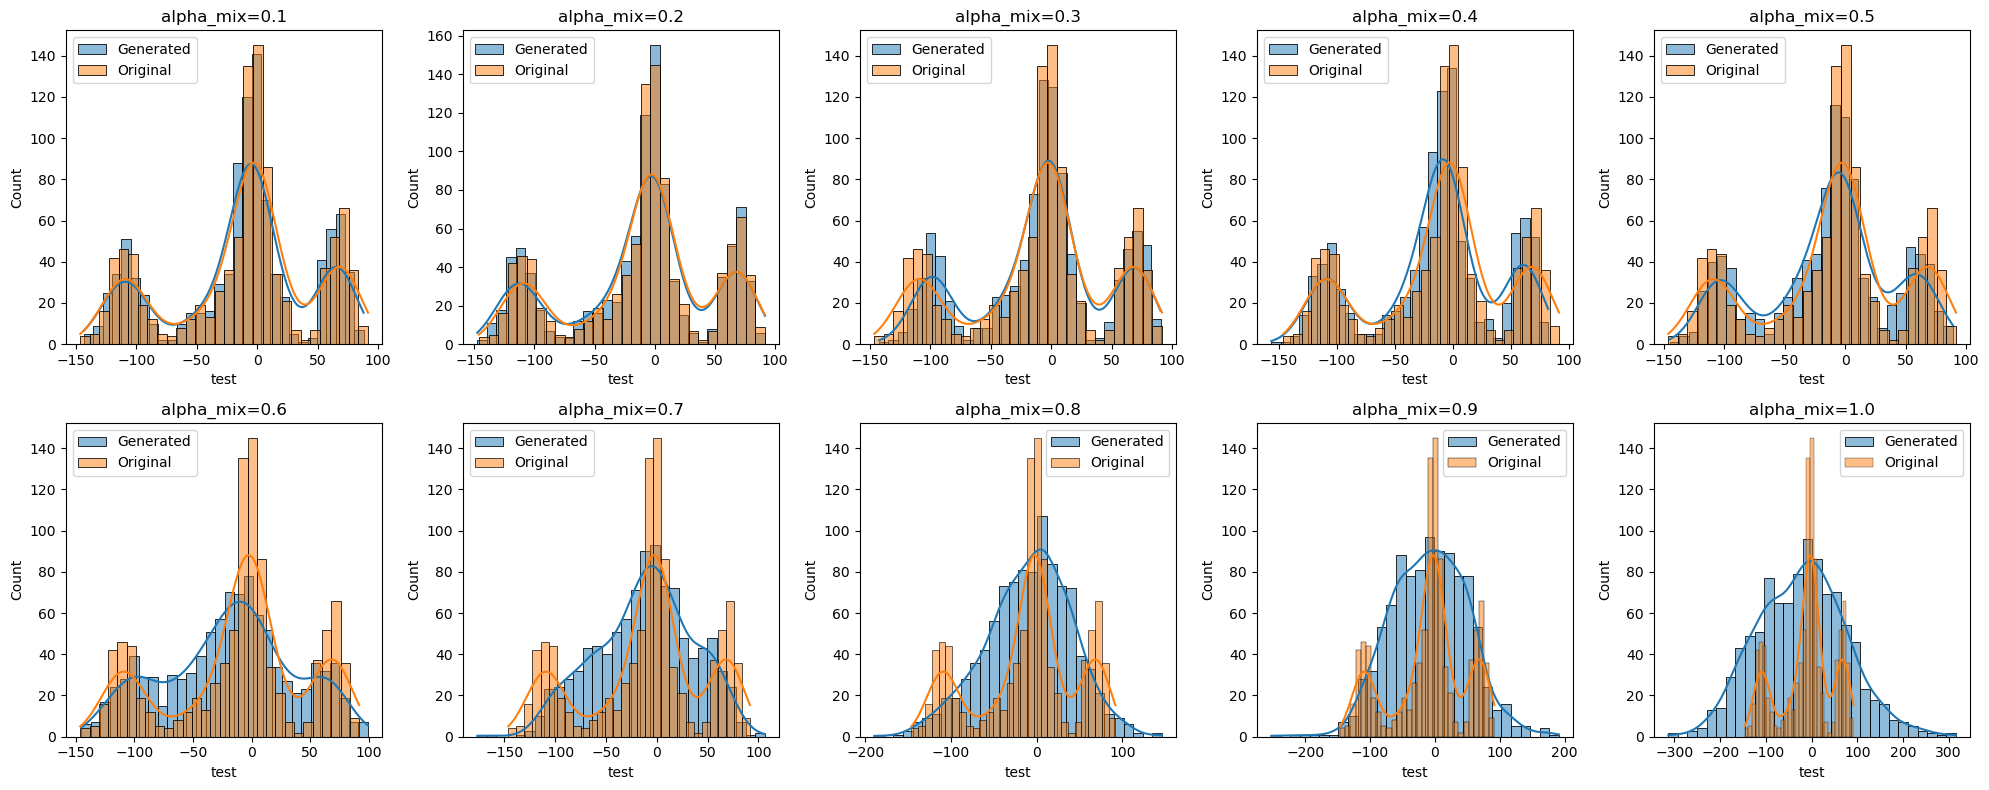

In [37]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
targetdim = 1
lambda1 = 0.5
alpha = 0.05
for i, alpha_mix in enumerate(np.linspace(0.1, 1, 10)):
    print(alpha_mix)
    model = Model(device, beta_1, beta_T, T, targetdim, condim,alpha_mix=alpha_mix,iftrained=False,trainedmodel=None)
    optimizer = torch.optim.Adam(list(model.backbone.parameters()) + list(model.quantile_backbone.parameters()), lr=1e-3)
    traincon_ddpm(model, optimizer, 100, 1, lambda1, alpha, sca_traindata_loader_5, sca_valdata_loader_5, 10)
    model.eval()
    diffusion = DiffusionProcess(beta_1, beta_T, T, model, device, 1, condim)
    sampling_number = sca_X_test_5.shape[0]
    only_final = True
    process = DiffusionProcess(beta_1, beta_T, T, model, device, (1,), torch.Tensor(sca_X_test_5[:,:-1]).cuda())
    sample = process.sampling(sampling_number, torch.Tensor(sca_X_test_5[:,:-1]).cuda(), only_final)
    trandatacvae = scay5.inverse_transform(sample.cpu().detach().numpy())
    ax = axes[i // 5, i % 5]
    sns.histplot(trandatacvae, kde=True, bins=30, label='Generated', ax=ax)
    sns.histplot(resultdata['test'], kde=True, bins=30, label='Original', ax=ax)
    ax.legend()
    ax.set_title(f'alpha_mix={alpha_mix:.1f}')

plt.tight_layout()
plt.savefig('generated_alpha_traintogether.png')
plt.show()

pretrain

In [11]:

alpha = 0.9
# 1. 创建模型
class QuantileBackbone(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU()
        )
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
        )
        
    def forward(self, x):   
        x = self.linear_model1(x)
        x = self.linear_model2(x)
        return x

    
    def loss_fn(self, y_pred, y_true, alpha):
        return torch.mean(torch.max(alpha * (y_true - y_pred), (alpha - 1) * (y_true - y_pred))) 
    
    


# 2. 准备数据（使用一些模拟数据作为示例）
input_dim = 2  # 假设输入特征维度为 10
output_dim = 1  # 假设输出为一个连续值（回归任务）

# 模拟数据
x_train = torch.tensor(sca_X_train_5[:,:-1]).cuda()
y_train = torch.tensor(sca_Y_train_5[:,-1].reshape(-1,1)).cuda()

# 3. 初始化模型、损失函数和优化器
qmodel = QuantileBackbone(input_dim, output_dim).cuda()
optimizer = optim.Adam(qmodel.parameters(), lr=0.001)


num_epochs = 1000
for epoch in range(num_epochs):
    qmodel.train()  # 设置模型为训练模式
    optimizer.zero_grad()  # 清零梯度
    y_pred = qmodel(x_train)
    loss = qmodel.loss_fn(y_pred, y_train, alpha)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [10/1000], Loss: 0.2393
Epoch [20/1000], Loss: 0.1977
Epoch [30/1000], Loss: 0.1518
Epoch [40/1000], Loss: 0.0959
Epoch [50/1000], Loss: 0.0712
Epoch [60/1000], Loss: 0.0613
Epoch [70/1000], Loss: 0.0549
Epoch [80/1000], Loss: 0.0476
Epoch [90/1000], Loss: 0.0399
Epoch [100/1000], Loss: 0.0318
Epoch [110/1000], Loss: 0.0255
Epoch [120/1000], Loss: 0.0224
Epoch [130/1000], Loss: 0.0201
Epoch [140/1000], Loss: 0.0189
Epoch [150/1000], Loss: 0.0178
Epoch [160/1000], Loss: 0.0169
Epoch [170/1000], Loss: 0.0162
Epoch [180/1000], Loss: 0.0155
Epoch [190/1000], Loss: 0.0149
Epoch [200/1000], Loss: 0.0143
Epoch [210/1000], Loss: 0.0138
Epoch [220/1000], Loss: 0.0132
Epoch [230/1000], Loss: 0.0126
Epoch [240/1000], Loss: 0.0121
Epoch [250/1000], Loss: 0.0116
Epoch [260/1000], Loss: 0.0111
Epoch [270/1000], Loss: 0.0106
Epoch [280/1000], Loss: 0.0101
Epoch [290/1000], Loss: 0.0098
Epoch [300/1000], Loss: 0.0094
Epoch [310/1000], Loss: 0.0092
Epoch [320/1000], Loss: 0.0089
Epoch [330/1000],

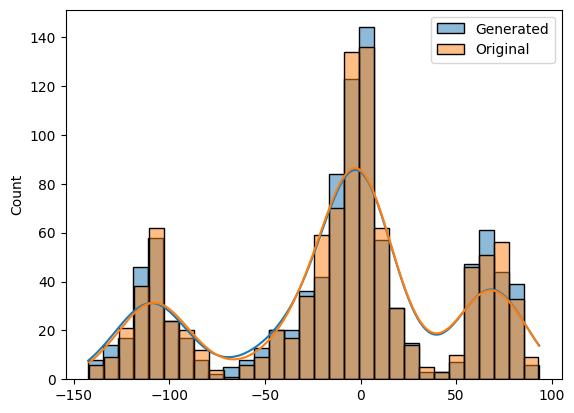

In [12]:
tr = scay5.inverse_transform((qmodel(torch.Tensor(sca_X_test_5[:,:-1]).cuda()).cuda()).cpu().detach().numpy())
sns.histplot(tr, kde=True, bins=30, label='Generated')
sns.histplot(X_test_5[:,-1], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例



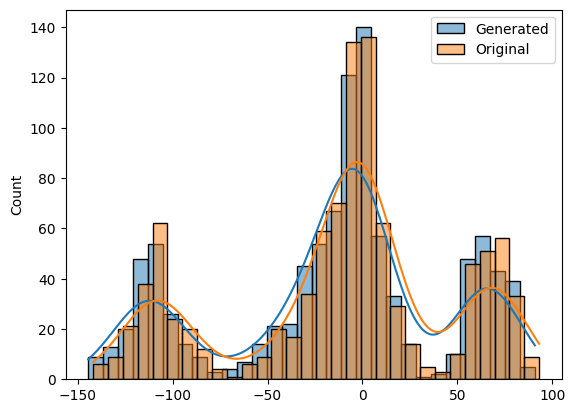

In [10]:
tr = scay5.inverse_transform((qmodel(torch.Tensor(sca_X_test_5[:,:-1]).cuda()).cuda()).cpu().detach().numpy())
sns.histplot(tr, kde=True, bins=30, label='Generated')
sns.histplot(X_test_5[:,-1], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例



In [165]:

class GNet0(nn.Module):
    def __init__(self,input_dim,  hidden_size = 32, alpha=0.5):
        super(GNet0, self).__init__()
        self.alpha = alpha
        #self.relu = nn.LeakyReLU(0.1)
        self.relu = nn.Tanh()#nn.ReLU()#nn.Tanh()#nn.ReLU()#nn.Tanh()#nn.Sigmoid()
        self.norm = nn.LayerNorm(hidden_size)
        
        
        self.fc0 = nn.Linear(input_dim, hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        
        self.fc_out1 = nn.Linear(hidden_size, hidden_size)
        self.fc_out2 = nn.Linear(hidden_size, hidden_size)
        self.z_out = nn.Linear(hidden_size, 1)
        
        #quantile z network
        self.z_0 = nn.Linear(1, hidden_size)
        self.z_1 = nn.Linear(hidden_size, hidden_size)
        self.z_2 = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, a):
        out1 = self.relu( self.fc0(x) )
        out1 = self.relu( self.fc1(out1) ) # + 0.1*self.fc0001(out) )
        out1 = self.relu( self.fc2(out1) ) #+ 0.1*self.fc0002(out)) #+ 0.3*self.fc000(out) )
        #u = 3
        #for j in range(L-1):
        #  out = self.layers[u*j](out)
        #  out = self.layers[u*j+1](out)# + self.layers[u*j+3](a)
        #  out = self.layers[u*j+2](out) #+ a#self.layers[u*j+4]( self.layers[u*j+3](a) )
        
        out_z = self.relu( self.z_0(a) )
        out_z = self.relu( self.z_1(out_z) ) #+ 0.1*self.fc01(a))
        out_z = self.relu( self.z_2(out_z) ) #+ 0.1*self.fc02(a))
        
        #out = torch.cat([out1, out_z], dim=1)
        out = out1 + out_z
        out = self.fc_out1(out) #+ 0.2*self.fc00(out00)
        #out = self.fc_out2( self.relu(out + 0.8*self.fc002(out00)) )
        out = self.z_out( self.relu(out) )
        #out = torch.sort(out)[0]
        
        return out 
    def loss_fn(self, y_pred, y_true):
        return torch.mean(torch.max(self.alpha * (y_true - y_pred), (self.alpha - 1) * (y_true - y_pred))) 

    def loss_fn_2(self, y_pred, y_pred2, y_true):
        Out_G = y_pred
        Out_G2 = y_pred2
        fac = 2
        dist = torch.abs(Out_G - Out_G2)
        sd_y = torch.std(y_true).item()
        pen = torch.log((dist / sd_y) + 1.0 / fac)
        return pen.mean()

# 2. 准备数据（使用一些模拟数据作为示例）
input_dim = 2  # 假设输入特征维度为 10
output_dim = 1  # 假设输出为一个连续值（回归任务）
alpha = 0.3
# 模拟数据
x_train = torch.tensor(sca_X_train_5[:,:-1]).cuda()
y_train = torch.tensor(sca_Y_train_5[:,-1].reshape(-1,1)).cuda()

# 3. 初始化模型、损失函数和优化器
qmodel = GNet0(input_dim,hidden_size=32,alpha = alpha).cuda()
optimizer = optim.Adam(qmodel.parameters(), lr=0.001)


num_epochs = 1000
for epoch in range(num_epochs):
    qmodel.train()  # 设置模型为训练模式
    optimizer.zero_grad()  # 清零梯度
    
    rand_aray = torch.rand_like(y_train).cuda()
    y_pred = qmodel(x_train,  alpha*torch.ones(X_train_5.shape[0],1).cuda() )
    y_pred2 = qmodel(x_train,rand_aray)
    loss = qmodel.loss_fn(y_pred, y_train)
    loss3 = qmodel.loss_fn_2(y_pred,y_pred2, y_train)
    loss-=loss3
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        



Epoch [10/1000], Loss: 0.9130
Epoch [20/1000], Loss: 0.6438
Epoch [30/1000], Loss: 0.2679
Epoch [40/1000], Loss: -0.2055
Epoch [50/1000], Loss: -0.6863
Epoch [60/1000], Loss: -1.0296
Epoch [70/1000], Loss: -1.2183
Epoch [80/1000], Loss: -1.3712
Epoch [90/1000], Loss: -1.4626
Epoch [100/1000], Loss: -1.5324
Epoch [110/1000], Loss: -1.5945
Epoch [120/1000], Loss: -1.6801
Epoch [130/1000], Loss: -1.7130
Epoch [140/1000], Loss: -1.7898
Epoch [150/1000], Loss: -1.8201
Epoch [160/1000], Loss: -1.8734
Epoch [170/1000], Loss: -1.9273
Epoch [180/1000], Loss: -1.9552
Epoch [190/1000], Loss: -1.9565
Epoch [200/1000], Loss: -2.0073
Epoch [210/1000], Loss: -2.0297
Epoch [220/1000], Loss: -2.0592
Epoch [230/1000], Loss: -2.0950
Epoch [240/1000], Loss: -2.1298
Epoch [250/1000], Loss: -2.1545
Epoch [260/1000], Loss: -2.1522
Epoch [270/1000], Loss: -2.1870
Epoch [280/1000], Loss: -2.1847
Epoch [290/1000], Loss: -2.1550
Epoch [300/1000], Loss: -2.2401
Epoch [310/1000], Loss: -2.2633
Epoch [320/1000], Lo

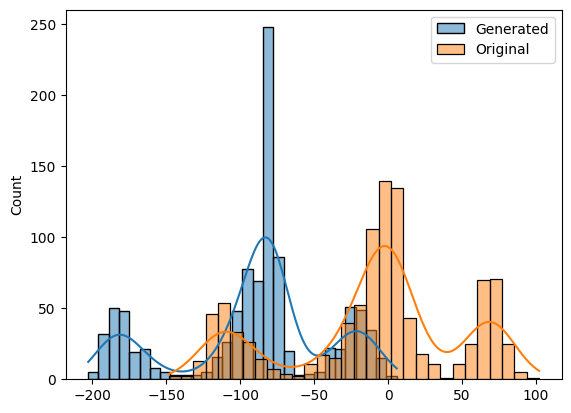

In [166]:
tr = scay5.inverse_transform((qmodel(torch.Tensor(sca_X_test_5[:,:-1]).cuda() ,   alpha*torch.ones(X_test_5.shape[0],1).cuda() ).cuda()).cpu().detach().numpy())
sns.histplot(tr, kde=True, bins=30, label='Generated')
sns.histplot(X_test_5[:,-1], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例

In [147]:
import torch
import torch.nn as nn

class GNet_selfattention(nn.Module):
    def __init__(self, input_dim, hidden_size=32, alpha=0.5):
        super(GNet_selfattention, self).__init__()
        self.alpha = alpha
        self.hidden_size = hidden_size
        self.relu = nn.Tanh()
        self.norm = nn.LayerNorm(hidden_size)
        
        # Fully connected layers
        self.fc0 = nn.Linear(input_dim, hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        
        self.fc_out1 = nn.Linear(hidden_size, hidden_size)
        self.fc_out2 = nn.Linear(hidden_size, hidden_size)
        self.z_out = nn.Linear(hidden_size, 1)
        
        # Attention mechanism layers for `a`
        self.attention_query = nn.Linear(1, hidden_size)
        self.attention_key = nn.Linear(1, hidden_size)
        self.attention_value = nn.Linear(1, hidden_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, a):
        # Process input `x`
        out1 = self.relu(self.fc0(x))
        out1 = self.relu(self.fc1(out1))
        out1 = self.relu(self.fc2(out1))
        
        # Self-attention mechanism for `a`
        query = self.attention_query(a)
        key = self.attention_key(a)
        value = self.attention_value(a)
        
        # Compute attention scores and apply to values
        attention_scores = torch.matmul(query, key.transpose(-2, -1)) / (self.hidden_size ** 0.5)
        attention_weights = self.softmax(attention_scores)
        out_z = torch.matmul(attention_weights, value)
        
        # Combine results
        out = out1 + out_z
        out = self.fc_out1(out)
        out = self.z_out(self.relu(out))
        
        return out 

    def loss_fn(self, y_pred, y_true):
        return torch.mean(torch.max(self.alpha * (y_true - y_pred), (self.alpha - 1) * (y_true - y_pred))) 

    def loss_fn_2(self, y_pred, y_pred2, y_true):
        Out_G = y_pred
        Out_G2 = y_pred2
        fac = 2
        dist = torch.abs(Out_G - Out_G2)
        sd_y = torch.std(y_true).item()
        pen = torch.log((dist / sd_y) + 1.0 )
        return pen.mean()


In [131]:
input_dim = 2  # 假设输入特征维度为 10
output_dim = 1  # 假设输出为一个连续值（回归任务）
alpha = 0.1
# 模拟数据
x_train = torch.tensor(sca_X_train_5[:,:-1]).cuda()
y_train = torch.tensor(sca_Y_train_5[:,-1].reshape(-1,1)).cuda()

# 3. 初始化模型、损失函数和优化器
qmodel = GNet_selfattention(input_dim,hidden_size=32,alpha = alpha).cuda()
optimizer = optim.Adam(qmodel.parameters(), lr=0.001)


num_epochs = 1000
for epoch in range(num_epochs):
    qmodel.train()  # 设置模型为训练模式
    optimizer.zero_grad()  # 清零梯度
    
    rand_aray = torch.rand_like(y_train).cuda()
    y_pred = qmodel(x_train,  alpha*torch.ones(X_train_5.shape[0],1).cuda() )
    y_pred2 = qmodel(x_train,rand_aray)
    loss = qmodel.loss_fn(y_pred, y_train)
    loss3 = qmodel.loss_fn_2(y_pred,y_pred2, y_train)
    loss-=loss3
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/1000], Loss: 0.0521
Epoch [20/1000], Loss: -0.2141
Epoch [30/1000], Loss: -0.3957
Epoch [40/1000], Loss: -0.5734
Epoch [50/1000], Loss: -0.7443
Epoch [60/1000], Loss: -0.9216
Epoch [70/1000], Loss: -1.0938
Epoch [80/1000], Loss: -1.2356
Epoch [90/1000], Loss: -1.3810
Epoch [100/1000], Loss: -1.5040
Epoch [110/1000], Loss: -1.5975
Epoch [120/1000], Loss: -1.7013
Epoch [130/1000], Loss: -1.7804
Epoch [140/1000], Loss: -1.8521
Epoch [150/1000], Loss: -1.9155
Epoch [160/1000], Loss: -1.9796
Epoch [170/1000], Loss: -2.0260
Epoch [180/1000], Loss: -2.0790
Epoch [190/1000], Loss: -2.1189
Epoch [200/1000], Loss: -2.1645
Epoch [210/1000], Loss: -2.2096
Epoch [220/1000], Loss: -2.2453
Epoch [230/1000], Loss: -2.2750
Epoch [240/1000], Loss: -2.2864
Epoch [250/1000], Loss: -2.3138
Epoch [260/1000], Loss: -2.3536
Epoch [270/1000], Loss: -2.3885
Epoch [280/1000], Loss: -2.4186
Epoch [290/1000], Loss: -2.4442
Epoch [300/1000], Loss: -2.4676
Epoch [310/1000], Loss: -2.4863
Epoch [320/1000], 

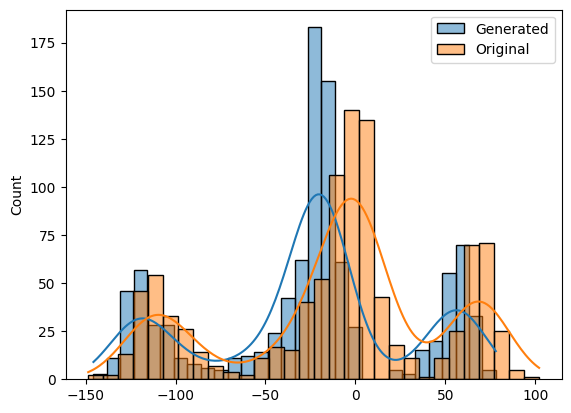

In [132]:
tr = scay5.inverse_transform((qmodel(torch.Tensor(sca_X_test_5[:,:-1]).cuda() ,   alpha*torch.ones(X_test_5.shape[0],1).cuda() ).cuda()).cpu().detach().numpy())
sns.histplot(tr, kde=True, bins=30, label='Generated')
sns.histplot(X_test_5[:,-1], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例

In [139]:
class GNet_multihead_attention(nn.Module):
    def __init__(self, input_dim, hidden_size=32, alpha=0.5, num_heads=4):
        super(GNet_multihead_attention, self).__init__()
        self.alpha = alpha
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.relu = nn.Tanh()
        self.norm = nn.LayerNorm(hidden_size)
        
        # Fully connected layers
        self.fc0 = nn.Linear(input_dim, hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size*self.num_heads, hidden_size)
        self.fc_out1 = nn.Linear(hidden_size, hidden_size)
        self.z_out = nn.Linear(hidden_size, 1)
        
        # Multi-head self-attention layers for `a`
        self.attention_query = nn.Linear(1, hidden_size * num_heads)
        self.attention_key = nn.Linear(1, hidden_size * num_heads)
        self.attention_value = nn.Linear(1, hidden_size * num_heads)
        self.softmax = nn.Softmax(dim=-1)

        
        self.embedding = nn.EmbeddingBag(100, 16, mode='mean')
        self.fc_emb = nn.Linear(16, hidden_size)
        
        
    def forward(self, x, a):
        # Process input `x`
        out1 = self.relu(self.fc0(x))
        out1 = self.relu(self.fc1(out1))
        out1 = self.relu(self.fc2(out1))
        
        # Multi-head self-attention for `a`
        query = self.attention_query(a).view(-1, self.num_heads, self.hidden_size)
        key = self.attention_key(a).view(-1, self.num_heads, self.hidden_size)
        value = self.attention_value(a).view(-1, self.num_heads, self.hidden_size)
        
        # Compute attention scores and apply to values
        attention_scores = torch.matmul(query, key.transpose(-2, -1)) / (self.hidden_size ** 0.5)
        attention_weights = self.softmax(attention_scores)
        out_z = torch.matmul(attention_weights, value).view(-1, self.hidden_size * self.num_heads)
        out_z = self.relu(self.fc3(out_z))
        
        
        a_emb = self.embedding(a.long())
        a_emb = self.relu(self.fc_emb(a_emb))
        
        
        
        # Combine results
        out = out1 + out_z+a_emb
        out = self.fc_out1(out)
        out = self.z_out(self.relu(out))
        
        return out
    def loss_fn(self, y_pred, y_true, quantile_list=np.linspace(0, 1, 11)):

        weight_list = np.exp(-np.abs(quantile_list - self.alpha))
        weight_list = weight_list / weight_list.sum()
        weight_list = torch.tensor(weight_list).cuda()
        
        # 计算 quantile_loss
        quantile_value = torch.tensor(np.percentile(y_true.detach().cpu().numpy(), quantile_list)).cuda()
        y_pred1 = y_pred.detach().cpu().numpy()
        quantile_predic = torch.tensor(np.percentile(y_pred1, quantile_list)).cuda()
        quantile_loss = torch.abs(quantile_value - quantile_predic)
        quantile_loss_std = torch.std(quantile_loss) + 1e-6  # 防止除以零
        quantile_loss_normalized = quantile_loss / quantile_loss_std
        
        # 计算 pinball_loss
        pinball_loss = torch.mean(torch.max(self.alpha * (y_true - y_pred), (self.alpha - 1) * (y_true - y_pred)))
        
        # 动态调整权重
        quantile_loss_mean = torch.mean(weight_list *quantile_loss_normalized)
        scaling_factor = quantile_loss_mean / (quantile_loss_mean + pinball_loss)
        dynamic_weight = 0.5 * scaling_factor  # 基于比例动态调整

        return pinball_loss + dynamic_weight * torch.mean(weight_list * quantile_loss_normalized)


    
    
    def loss_fn_2(self, y_pred, y_pred2, y_true):
        Out_G = y_pred
        Out_G2 = y_pred2
        fac = 2
        dist = torch.abs(Out_G - Out_G2)
        sd_y = torch.std(y_true).item()
        pen = torch.log((dist / sd_y) + 1.0 / fac)
        return pen.mean()


In [140]:
input_dim = 2  # 假设输入特征维度为 10
output_dim = 1  # 假设输出为一个连续值（回归任务）
alpha = 0.1

# 模拟数据
x_train = torch.tensor(sca_X_train_5[:,:-1]).cuda()
y_train = torch.tensor(sca_Y_train_5[:,-1].reshape(-1,1)).cuda()
x_val = torch.tensor(sca_X_val_5[:,:-1]).cuda()
y_val = torch.tensor(sca_X_val_5[:,-1].reshape(-1,1)).cuda()
# 3. 初始化模型、损失函数和优化器







def trainGmul(x_train,y_train,x_val,y_val,alpha,ifattention = False):
    if ifattention:
        qmodel = GNet_multihead_attention(input_dim,hidden_size=32,alpha = alpha).cuda()
    else:
        qmodel = GNet0(input_dim,hidden_size=32,alpha = alpha).cuda()
    # qmodel = GNet0(input_dim,hidden_size=32,alpha = alpha).cuda()
    optimizer = optim.Adam(qmodel.parameters(), lr=0.001)


    # 假设验证集是 x_val, y_val
    early_stopping_patience = 500  # 如果连续 100 个 epoch 验证损失不降低，则停止训练
    best_loss = float('inf')  # 用于记录验证集上的最优损失
    patience_counter = 0  # 记录验证损失未降低的连续 epoch 数

    num_epochs = 2000
    for epoch in range(num_epochs):
        qmodel.train()  # 设置模型为训练模式
        optimizer.zero_grad()  # 清零梯度
        
        # 训练集前向传播和损失计算
        rand_aray = torch.rand_like(y_train).cuda()
        y_pred = qmodel(x_train, alpha * torch.ones(x_train.shape[0], 1).cuda())
        y_pred2 = qmodel(x_train, rand_aray)
        loss = qmodel.loss_fn(y_pred, y_train)
        loss3 = qmodel.loss_fn_2(y_pred, y_pred2, y_train)
        loss -= loss3
        loss.backward()
        optimizer.step()
        
        # 验证集前向传播和损失计算
        qmodel.eval()  # 设置模型为评估模式
        with torch.no_grad():
            val_pred = qmodel(x_val, alpha * torch.ones(x_val.shape[0], 1).cuda())
            val_loss = qmodel.loss_fn(val_pred, y_val)

        # Early Stopping 检测
        if val_loss.item() < best_loss:
            best_loss = val_loss.item()  # 更新最优验证损失
            patience_counter = 0  # 重置计数器
            # 可以保存当前最优模型
            torch.save(qmodel.state_dict(), "best_model.pth")
        else:
            patience_counter += 1  # 增加计数器

        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        # 每隔 10 个 epoch 打印一次训练和验证损失
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

0.05
Epoch [10/2000], Loss: 1.1862, Val Loss: 0.8726
Epoch [20/2000], Loss: 0.4777, Val Loss: 0.6355
Epoch [30/2000], Loss: -0.1050, Val Loss: 0.3736
Epoch [40/2000], Loss: -0.3651, Val Loss: 0.4420
Epoch [50/2000], Loss: -0.6138, Val Loss: 0.3412
Epoch [60/2000], Loss: -0.9433, Val Loss: 0.2473
Epoch [70/2000], Loss: -1.1942, Val Loss: 0.1304
Epoch [80/2000], Loss: -1.3333, Val Loss: 0.1324
Epoch [90/2000], Loss: -1.4467, Val Loss: 0.1082
Epoch [100/2000], Loss: -1.3706, Val Loss: 0.1203
Epoch [110/2000], Loss: -1.3399, Val Loss: 0.1213
Epoch [120/2000], Loss: -1.4936, Val Loss: 0.1814
Epoch [130/2000], Loss: -1.2837, Val Loss: 0.2342
Epoch [140/2000], Loss: -1.3719, Val Loss: 0.2400
Epoch [150/2000], Loss: -1.2587, Val Loss: 0.2960
Epoch [160/2000], Loss: -0.6279, Val Loss: 0.5853
Epoch [170/2000], Loss: -1.6053, Val Loss: 0.4784
Epoch [180/2000], Loss: -1.5188, Val Loss: 0.4052
Epoch [190/2000], Loss: -1.2969, Val Loss: 0.3410
Epoch [200/2000], Loss: -1.7235, Val Loss: 0.3722
Epoch 

C:\Users\19513\AppData\Local\Temp\ipykernel_13388\755766015.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


0.15
Epoch [10/2000], Loss: 1.2713, Val Loss: 0.7650
Epoch [20/2000], Loss: 0.4329, Val Loss: 0.4107
Epoch [30/2000], Loss: -0.3441, Val Loss: 0.1587
Epoch [40/2000], Loss: -0.5724, Val Loss: 0.2570
Epoch [50/2000], Loss: -0.8734, Val Loss: 0.1979
Epoch [60/2000], Loss: -1.0821, Val Loss: 0.1755
Epoch [70/2000], Loss: -1.2721, Val Loss: 0.1216
Epoch [80/2000], Loss: -1.3727, Val Loss: 0.3292
Epoch [90/2000], Loss: -1.3569, Val Loss: 0.0934
Epoch [100/2000], Loss: -0.4130, Val Loss: 0.8317
Epoch [110/2000], Loss: -0.1715, Val Loss: 1.2926
Epoch [120/2000], Loss: -1.1685, Val Loss: 0.5398
Epoch [130/2000], Loss: 0.0075, Val Loss: 1.2269
Epoch [140/2000], Loss: -0.3372, Val Loss: 0.5970
Epoch [150/2000], Loss: -0.9274, Val Loss: 0.5258
Epoch [160/2000], Loss: -0.1952, Val Loss: 0.3123
Epoch [170/2000], Loss: -1.1497, Val Loss: 0.4265
Epoch [180/2000], Loss: 2.0408, Val Loss: 1.9687
Epoch [190/2000], Loss: -0.1555, Val Loss: 0.2153
Epoch [200/2000], Loss: -1.0873, Val Loss: 0.2246
Epoch [2

C:\Users\19513\AppData\Local\Temp\ipykernel_13388\755766015.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


0.25
Epoch [10/2000], Loss: 1.4574, Val Loss: 0.9276
Epoch [20/2000], Loss: 0.5993, Val Loss: 0.5389
Epoch [30/2000], Loss: -0.1842, Val Loss: 0.2948
Epoch [40/2000], Loss: -0.5120, Val Loss: 0.2650
Epoch [50/2000], Loss: -0.8416, Val Loss: 0.1952
Epoch [60/2000], Loss: -1.0860, Val Loss: 0.0973
Epoch [70/2000], Loss: -0.9377, Val Loss: 0.2642
Epoch [80/2000], Loss: -1.1224, Val Loss: 0.1762
Epoch [90/2000], Loss: -1.3587, Val Loss: 0.4956
Epoch [100/2000], Loss: -0.5622, Val Loss: 0.7480
Epoch [110/2000], Loss: -1.3157, Val Loss: 0.3246
Epoch [120/2000], Loss: 0.6718, Val Loss: 1.1892
Epoch [130/2000], Loss: -1.5205, Val Loss: 0.1882
Epoch [140/2000], Loss: -1.0605, Val Loss: 0.4579
Epoch [150/2000], Loss: -1.0759, Val Loss: 0.1662
Epoch [160/2000], Loss: -0.3274, Val Loss: 0.6430
Epoch [170/2000], Loss: -1.0297, Val Loss: 0.4229
Epoch [180/2000], Loss: -1.0713, Val Loss: 0.1363
Epoch [190/2000], Loss: -1.6982, Val Loss: 0.6642
Epoch [200/2000], Loss: -0.7097, Val Loss: 0.6776
Epoch [

C:\Users\19513\AppData\Local\Temp\ipykernel_13388\755766015.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


Epoch [10/2000], Loss: 1.5444, Val Loss: 0.9934
Epoch [20/2000], Loss: 1.0990, Val Loss: 0.8601
Epoch [30/2000], Loss: 1.2342, Val Loss: 0.9882
Epoch [40/2000], Loss: 0.7311, Val Loss: 0.8660
Epoch [50/2000], Loss: 1.6176, Val Loss: 1.0189
Epoch [60/2000], Loss: 1.4171, Val Loss: 0.6972
Epoch [70/2000], Loss: -0.6568, Val Loss: 0.1527
Epoch [80/2000], Loss: -0.1528, Val Loss: 0.2672
Epoch [90/2000], Loss: -1.2809, Val Loss: 0.2217
Epoch [100/2000], Loss: -1.4996, Val Loss: 0.3409
Epoch [110/2000], Loss: -1.0169, Val Loss: 0.2812
Epoch [120/2000], Loss: -1.1722, Val Loss: 0.1557
Epoch [130/2000], Loss: -1.6317, Val Loss: 0.4430
Epoch [140/2000], Loss: -1.3018, Val Loss: 0.3575
Epoch [150/2000], Loss: -1.0190, Val Loss: 0.7440
Epoch [160/2000], Loss: -0.9118, Val Loss: 0.9322
Epoch [170/2000], Loss: -1.5292, Val Loss: 0.8594
Epoch [180/2000], Loss: -1.3622, Val Loss: 0.8358
Epoch [190/2000], Loss: -1.6612, Val Loss: 0.2556
Epoch [200/2000], Loss: -1.4730, Val Loss: 0.6949
Epoch [210/2000

C:\Users\19513\AppData\Local\Temp\ipykernel_13388\755766015.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


Epoch [10/2000], Loss: 1.6487, Val Loss: 1.0990
Epoch [20/2000], Loss: 1.0675, Val Loss: 0.8827
Epoch [30/2000], Loss: 0.5742, Val Loss: 0.7861
Epoch [40/2000], Loss: 1.6809, Val Loss: 0.9110
Epoch [50/2000], Loss: -0.1343, Val Loss: 0.3657
Epoch [60/2000], Loss: -0.7620, Val Loss: 0.1342
Epoch [70/2000], Loss: -0.9766, Val Loss: 0.1201
Epoch [80/2000], Loss: -0.8991, Val Loss: 0.1118
Epoch [90/2000], Loss: -1.3868, Val Loss: 0.1120
Epoch [100/2000], Loss: -1.1688, Val Loss: 0.1472
Epoch [110/2000], Loss: -1.5042, Val Loss: 0.2424
Epoch [120/2000], Loss: -1.2416, Val Loss: 0.1331
Epoch [130/2000], Loss: -1.4864, Val Loss: 0.1052
Epoch [140/2000], Loss: -1.1873, Val Loss: 0.1076
Epoch [150/2000], Loss: -1.5592, Val Loss: 0.1922
Epoch [160/2000], Loss: -1.3531, Val Loss: 0.1131
Epoch [170/2000], Loss: 0.8144, Val Loss: 1.2892
Epoch [180/2000], Loss: 0.7537, Val Loss: 1.3195
Epoch [190/2000], Loss: 1.0862, Val Loss: 1.7252
Epoch [200/2000], Loss: 1.2063, Val Loss: 0.4015
Epoch [210/2000],

C:\Users\19513\AppData\Local\Temp\ipykernel_13388\755766015.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


Epoch [20/2000], Loss: 1.0801, Val Loss: 0.9354
Epoch [30/2000], Loss: 0.9542, Val Loss: 0.8231
Epoch [40/2000], Loss: 0.8638, Val Loss: 0.9138
Epoch [50/2000], Loss: -0.6078, Val Loss: 0.2824
Epoch [60/2000], Loss: -1.0436, Val Loss: 0.1137
Epoch [70/2000], Loss: -1.3283, Val Loss: 0.1490
Epoch [80/2000], Loss: -1.1832, Val Loss: 0.2207
Epoch [90/2000], Loss: -1.3694, Val Loss: 0.1044
Epoch [100/2000], Loss: -1.5751, Val Loss: 0.0784
Epoch [110/2000], Loss: -1.4062, Val Loss: 0.1611
Epoch [120/2000], Loss: -0.9206, Val Loss: 0.5071
Epoch [130/2000], Loss: -1.6087, Val Loss: 0.0858
Epoch [140/2000], Loss: -1.3029, Val Loss: 0.5398
Epoch [150/2000], Loss: -1.4037, Val Loss: 0.2386
Epoch [160/2000], Loss: -1.6884, Val Loss: 0.4194
Epoch [170/2000], Loss: -1.8666, Val Loss: 0.5567
Epoch [180/2000], Loss: -1.1508, Val Loss: 0.1095
Epoch [190/2000], Loss: -1.2589, Val Loss: 0.1627
Epoch [200/2000], Loss: -1.1385, Val Loss: 0.2827
Epoch [210/2000], Loss: -1.2874, Val Loss: 0.3918
Epoch [220/

C:\Users\19513\AppData\Local\Temp\ipykernel_13388\755766015.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


0.65
Epoch [10/2000], Loss: 1.7464, Val Loss: 1.1191
Epoch [20/2000], Loss: 1.3184, Val Loss: 0.9839
Epoch [30/2000], Loss: 0.8978, Val Loss: 0.8996
Epoch [40/2000], Loss: 1.0096, Val Loss: 0.9301
Epoch [50/2000], Loss: -0.2510, Val Loss: 0.4523
Epoch [60/2000], Loss: -0.9390, Val Loss: 0.0940
Epoch [70/2000], Loss: -1.1119, Val Loss: 0.0965
Epoch [80/2000], Loss: -1.2695, Val Loss: 0.3198
Epoch [90/2000], Loss: -1.2409, Val Loss: 0.0994
Epoch [100/2000], Loss: -1.0994, Val Loss: 0.1605
Epoch [110/2000], Loss: -1.2669, Val Loss: 0.1067
Epoch [120/2000], Loss: -1.5903, Val Loss: 0.1196
Epoch [130/2000], Loss: -1.5488, Val Loss: 0.1875
Epoch [140/2000], Loss: -1.7104, Val Loss: 0.2038
Epoch [150/2000], Loss: -1.5629, Val Loss: 0.1358
Epoch [160/2000], Loss: -1.7897, Val Loss: 0.1670
Epoch [170/2000], Loss: -1.5394, Val Loss: 0.1348
Epoch [180/2000], Loss: -1.4745, Val Loss: 0.0793
Epoch [190/2000], Loss: -1.3686, Val Loss: 0.3897
Epoch [200/2000], Loss: -1.4841, Val Loss: 0.8226
Epoch [2

C:\Users\19513\AppData\Local\Temp\ipykernel_13388\755766015.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


Epoch [10/2000], Loss: 1.9925, Val Loss: 1.3842
Epoch [20/2000], Loss: 1.6025, Val Loss: 1.2684
Epoch [30/2000], Loss: 0.8552, Val Loss: 0.9555
Epoch [40/2000], Loss: 0.4719, Val Loss: 1.0097
Epoch [50/2000], Loss: 0.2461, Val Loss: 1.0257
Epoch [60/2000], Loss: 0.0367, Val Loss: 1.0389
Epoch [70/2000], Loss: -0.2190, Val Loss: 0.9851
Epoch [80/2000], Loss: -0.2415, Val Loss: 1.0886
Epoch [90/2000], Loss: -0.8634, Val Loss: 0.4949
Epoch [100/2000], Loss: -0.6737, Val Loss: 0.6529
Epoch [110/2000], Loss: -1.0973, Val Loss: 0.5265
Epoch [120/2000], Loss: -1.0084, Val Loss: 0.5286
Epoch [130/2000], Loss: 0.4195, Val Loss: 2.5389
Epoch [140/2000], Loss: 0.5973, Val Loss: 2.5482
Epoch [150/2000], Loss: -0.0471, Val Loss: 1.7905
Epoch [160/2000], Loss: -0.6814, Val Loss: 0.8093
Epoch [170/2000], Loss: -1.6930, Val Loss: 0.3178
Epoch [180/2000], Loss: -1.7299, Val Loss: 0.5062
Epoch [190/2000], Loss: -1.5883, Val Loss: 0.2953
Epoch [200/2000], Loss: -1.5185, Val Loss: 0.1753
Epoch [210/2000],

C:\Users\19513\AppData\Local\Temp\ipykernel_13388\755766015.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


0.85
Epoch [10/2000], Loss: 1.6573, Val Loss: 1.1564
Epoch [20/2000], Loss: 1.2082, Val Loss: 0.9946
Epoch [30/2000], Loss: 1.2007, Val Loss: 0.9412
Epoch [40/2000], Loss: 1.7167, Val Loss: 1.1482
Epoch [50/2000], Loss: 1.2175, Val Loss: 0.8175
Epoch [60/2000], Loss: -0.9978, Val Loss: 0.1409
Epoch [70/2000], Loss: -1.2803, Val Loss: 0.1538
Epoch [80/2000], Loss: -1.3509, Val Loss: 0.0969
Epoch [90/2000], Loss: -1.1207, Val Loss: 0.1145
Epoch [100/2000], Loss: -1.4804, Val Loss: 0.2374
Epoch [110/2000], Loss: -1.4755, Val Loss: 0.1115
Epoch [120/2000], Loss: -1.5525, Val Loss: 0.1560
Epoch [130/2000], Loss: -1.6234, Val Loss: 0.0961
Epoch [140/2000], Loss: -1.1106, Val Loss: 0.5597
Epoch [150/2000], Loss: -1.5518, Val Loss: 0.3891
Epoch [160/2000], Loss: -1.6371, Val Loss: 0.2510
Epoch [170/2000], Loss: -0.8833, Val Loss: 0.2739
Epoch [180/2000], Loss: -0.8132, Val Loss: 0.7879
Epoch [190/2000], Loss: -1.8635, Val Loss: 0.5002
Epoch [200/2000], Loss: -1.7498, Val Loss: 0.3192
Epoch [21

C:\Users\19513\AppData\Local\Temp\ipykernel_13388\755766015.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


Epoch [10/2000], Loss: 1.3873, Val Loss: 1.0556
Epoch [20/2000], Loss: 0.9255, Val Loss: 0.9637
Epoch [30/2000], Loss: 1.4460, Val Loss: 1.0210
Epoch [40/2000], Loss: 3.5103, Val Loss: 1.1358
Epoch [50/2000], Loss: 0.8047, Val Loss: 0.6849
Epoch [60/2000], Loss: -1.0819, Val Loss: 0.1148
Epoch [70/2000], Loss: -1.0770, Val Loss: 0.1303
Epoch [80/2000], Loss: -1.0436, Val Loss: 0.1412
Epoch [90/2000], Loss: -1.0038, Val Loss: 0.1869
Epoch [100/2000], Loss: -1.2960, Val Loss: 0.1229
Epoch [110/2000], Loss: -1.3012, Val Loss: 0.0650
Epoch [120/2000], Loss: -1.4898, Val Loss: 0.0966
Epoch [130/2000], Loss: -1.6077, Val Loss: 0.0941
Epoch [140/2000], Loss: -0.8511, Val Loss: 0.0894
Epoch [150/2000], Loss: -1.3860, Val Loss: 0.1227
Epoch [160/2000], Loss: -1.5863, Val Loss: 0.0832
Epoch [170/2000], Loss: -1.2222, Val Loss: 0.0906
Epoch [180/2000], Loss: -0.6354, Val Loss: 0.6756
Epoch [190/2000], Loss: -1.0983, Val Loss: 0.5695
Epoch [200/2000], Loss: -1.6564, Val Loss: 0.4212
Epoch [210/200

C:\Users\19513\AppData\Local\Temp\ipykernel_13388\755766015.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


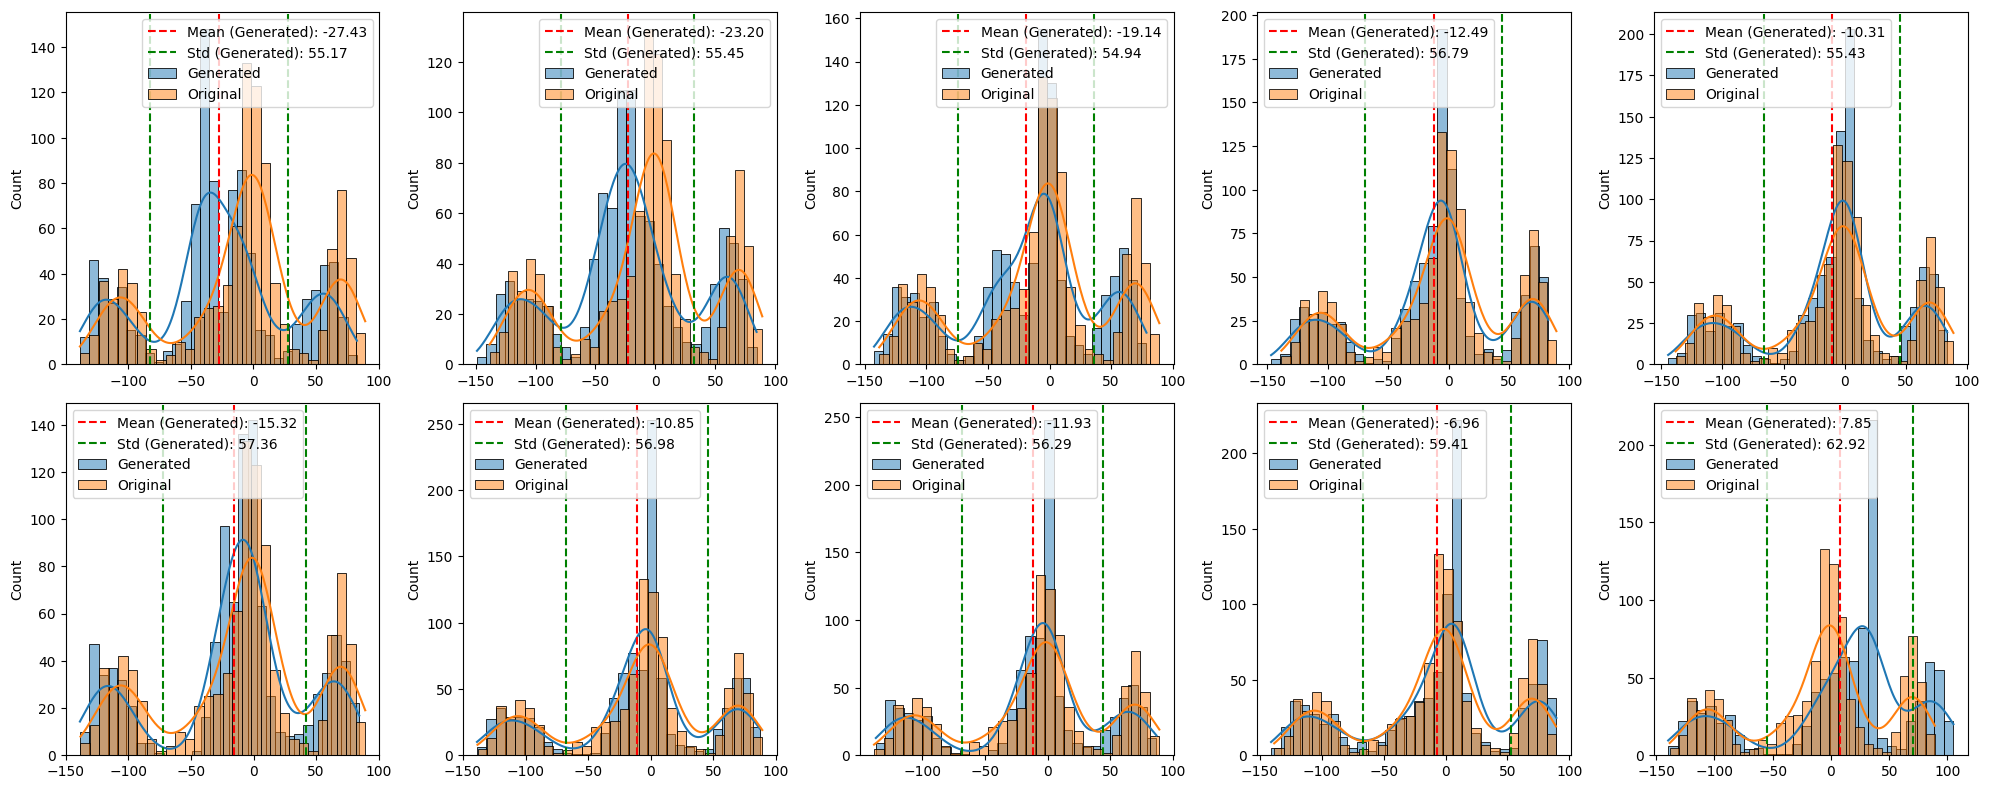

<Figure size 640x480 with 0 Axes>

In [141]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, alpha_mix in enumerate(np.linspace(0.05, 0.95, 10)):
    print(np.round(alpha_mix, 2))
    trainGmul(x_train, y_train, x_val, y_val, alpha_mix,True)
    ax = axes[i // 5, i % 5]
    qmodel = GNet_multihead_attention(input_dim, hidden_size=32, alpha=alpha_mix).cuda()
    qmodel.load_state_dict(torch.load("best_model.pth"))
    tr = scay5.inverse_transform((qmodel(torch.Tensor(sca_X_test_5[:,:-1]).cuda(), alpha_mix * torch.ones(X_test_5.shape[0], 1).cuda()).cuda()).cpu().detach().numpy())

    # 计算生成数据的均值和方差
    mean_generated = np.mean(tr)
    std_generated = np.std(tr)

    sns.histplot(tr, kde=True, bins=30, label='Generated', ax=ax)
    sns.histplot(X_test_5[:,-1], kde=True, bins=30, label='Original', ax=ax)

    # 添加生成数据的均值和方差线
    ax.axvline(mean_generated, color='r', linestyle='--', label=f'Mean (Generated): {mean_generated:.2f}')
    ax.axvline(mean_generated + std_generated, color='g', linestyle='--', label=f'Std (Generated): {std_generated:.2f}')
    ax.axvline(mean_generated - std_generated, color='g', linestyle='--')

    ax.legend()  # 添加图例

plt.tight_layout()
plt.show()
plt.savefig('generatedm_alpha_mix.png')

0.05
Epoch [10/2000], Loss: 0.7035, Val Loss: 0.2201
Epoch [20/2000], Loss: 0.2921, Val Loss: 0.0871
Epoch [30/2000], Loss: -0.1016, Val Loss: 0.0872
Epoch [40/2000], Loss: -0.5386, Val Loss: 0.0774
Epoch [50/2000], Loss: -0.8613, Val Loss: 0.0452
Epoch [60/2000], Loss: -1.1350, Val Loss: 0.0417
Epoch [70/2000], Loss: -1.3200, Val Loss: 0.0186
Epoch [80/2000], Loss: -1.4233, Val Loss: 0.0326
Epoch [90/2000], Loss: -1.5238, Val Loss: 0.0460
Epoch [100/2000], Loss: -1.5855, Val Loss: 0.0181
Epoch [110/2000], Loss: -1.6502, Val Loss: 0.0164
Epoch [120/2000], Loss: -1.7037, Val Loss: 0.0469
Epoch [130/2000], Loss: -1.7597, Val Loss: 0.0212
Epoch [140/2000], Loss: -1.7750, Val Loss: 0.0256
Epoch [150/2000], Loss: -1.8472, Val Loss: 0.0190
Epoch [160/2000], Loss: -1.8787, Val Loss: 0.0217
Epoch [170/2000], Loss: -1.8628, Val Loss: 0.0369
Epoch [180/2000], Loss: -1.9673, Val Loss: 0.0173
Epoch [190/2000], Loss: -1.9941, Val Loss: 0.0166
Epoch [200/2000], Loss: -2.0124, Val Loss: 0.0158
Epoch 

C:\Users\19513\AppData\Local\Temp\ipykernel_6536\2430442496.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


Epoch [20/2000], Loss: 0.4384, Val Loss: 0.1764
Epoch [30/2000], Loss: 0.0333, Val Loss: 0.1342
Epoch [40/2000], Loss: -0.3917, Val Loss: 0.1198
Epoch [50/2000], Loss: -0.7213, Val Loss: 0.1044
Epoch [60/2000], Loss: -0.9811, Val Loss: 0.0991
Epoch [70/2000], Loss: -1.1710, Val Loss: 0.0739
Epoch [80/2000], Loss: -1.3012, Val Loss: 0.0841
Epoch [90/2000], Loss: -1.3928, Val Loss: 0.0855
Epoch [100/2000], Loss: -1.4737, Val Loss: 0.1465
Epoch [110/2000], Loss: -1.5234, Val Loss: 0.1461
Epoch [120/2000], Loss: -1.5800, Val Loss: 0.1460
Epoch [130/2000], Loss: -1.6768, Val Loss: 0.0624
Epoch [140/2000], Loss: -1.7302, Val Loss: 0.0798
Epoch [150/2000], Loss: -1.7824, Val Loss: 0.0724
Epoch [160/2000], Loss: -1.8302, Val Loss: 0.0517
Epoch [170/2000], Loss: -1.7327, Val Loss: 0.3273
Epoch [180/2000], Loss: -1.8655, Val Loss: 0.0923
Epoch [190/2000], Loss: -1.9302, Val Loss: 0.1532
Epoch [200/2000], Loss: -1.8947, Val Loss: 0.1758
Epoch [210/2000], Loss: -1.9832, Val Loss: 0.0897
Epoch [220

C:\Users\19513\AppData\Local\Temp\ipykernel_6536\2430442496.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


Epoch [10/2000], Loss: 0.7885, Val Loss: 0.2891
Epoch [20/2000], Loss: 0.4354, Val Loss: 0.2347
Epoch [30/2000], Loss: 0.0191, Val Loss: 0.1878
Epoch [40/2000], Loss: -0.4333, Val Loss: 0.1533
Epoch [50/2000], Loss: -0.8541, Val Loss: 0.0715
Epoch [60/2000], Loss: -1.1155, Val Loss: 0.0649
Epoch [70/2000], Loss: -1.2820, Val Loss: 0.0569
Epoch [80/2000], Loss: -1.4003, Val Loss: 0.0560
Epoch [90/2000], Loss: -1.4960, Val Loss: 0.0547
Epoch [100/2000], Loss: -1.5749, Val Loss: 0.0601
Epoch [110/2000], Loss: -1.6459, Val Loss: 0.0523
Epoch [120/2000], Loss: -1.6899, Val Loss: 0.0627
Epoch [130/2000], Loss: -1.7344, Val Loss: 0.0445
Epoch [140/2000], Loss: -1.8112, Val Loss: 0.0465
Epoch [150/2000], Loss: -1.8496, Val Loss: 0.0488
Epoch [160/2000], Loss: -1.8935, Val Loss: 0.0510
Epoch [170/2000], Loss: -1.9405, Val Loss: 0.0412
Epoch [180/2000], Loss: -1.9310, Val Loss: 0.1982
Epoch [190/2000], Loss: -1.9330, Val Loss: 0.3053
Epoch [200/2000], Loss: -1.9067, Val Loss: 0.1658
Epoch [210/2

C:\Users\19513\AppData\Local\Temp\ipykernel_6536\2430442496.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


0.35
Epoch [10/2000], Loss: 0.9572, Val Loss: 0.3393
Epoch [20/2000], Loss: 0.7295, Val Loss: 0.2913
Epoch [30/2000], Loss: 0.4034, Val Loss: 0.2629
Epoch [40/2000], Loss: -0.0356, Val Loss: 0.2351
Epoch [50/2000], Loss: -0.5005, Val Loss: 0.1645
Epoch [60/2000], Loss: -0.9125, Val Loss: 0.0593
Epoch [70/2000], Loss: -1.1031, Val Loss: 0.0887
Epoch [80/2000], Loss: -1.2718, Val Loss: 0.0928
Epoch [90/2000], Loss: -1.3375, Val Loss: 0.0918
Epoch [100/2000], Loss: -1.4424, Val Loss: 0.0581
Epoch [110/2000], Loss: -1.5393, Val Loss: 0.0828
Epoch [120/2000], Loss: -1.5901, Val Loss: 0.0610
Epoch [130/2000], Loss: -1.6623, Val Loss: 0.0553
Epoch [140/2000], Loss: -1.6973, Val Loss: 0.0736
Epoch [150/2000], Loss: -1.7545, Val Loss: 0.0830
Epoch [160/2000], Loss: -1.8002, Val Loss: 0.0585
Epoch [170/2000], Loss: -1.7940, Val Loss: 0.0613
Epoch [180/2000], Loss: -1.8612, Val Loss: 0.1950
Epoch [190/2000], Loss: -1.8719, Val Loss: 0.1369
Epoch [200/2000], Loss: -1.7688, Val Loss: 0.0791
Epoch [

C:\Users\19513\AppData\Local\Temp\ipykernel_6536\2430442496.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


Epoch [30/2000], Loss: 0.1498, Val Loss: 0.2298
Epoch [40/2000], Loss: -0.3220, Val Loss: 0.1637
Epoch [50/2000], Loss: -0.7975, Val Loss: 0.0849
Epoch [60/2000], Loss: -1.0561, Val Loss: 0.0812
Epoch [70/2000], Loss: -1.2517, Val Loss: 0.1100
Epoch [80/2000], Loss: -1.3451, Val Loss: 0.1239
Epoch [90/2000], Loss: -1.4511, Val Loss: 0.0955
Epoch [100/2000], Loss: -1.5354, Val Loss: 0.0779
Epoch [110/2000], Loss: -1.6338, Val Loss: 0.0680
Epoch [120/2000], Loss: -1.6947, Val Loss: 0.0588
Epoch [130/2000], Loss: -1.7555, Val Loss: 0.0901
Epoch [140/2000], Loss: -1.7729, Val Loss: 0.0670
Epoch [150/2000], Loss: -1.8398, Val Loss: 0.0560
Epoch [160/2000], Loss: -1.8966, Val Loss: 0.1088
Epoch [170/2000], Loss: -1.9095, Val Loss: 0.0830
Epoch [180/2000], Loss: -1.9682, Val Loss: 0.1143
Epoch [190/2000], Loss: -2.0004, Val Loss: 0.0598
Epoch [200/2000], Loss: -2.0098, Val Loss: 0.1057
Epoch [210/2000], Loss: -2.0617, Val Loss: 0.0761
Epoch [220/2000], Loss: -2.0707, Val Loss: 0.0623
Epoch [2

C:\Users\19513\AppData\Local\Temp\ipykernel_6536\2430442496.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


Epoch [10/2000], Loss: 0.8786, Val Loss: 0.3328
Epoch [20/2000], Loss: 0.6020, Val Loss: 0.2767
Epoch [30/2000], Loss: 0.2428, Val Loss: 0.2482
Epoch [40/2000], Loss: -0.2142, Val Loss: 0.2029
Epoch [50/2000], Loss: -0.6985, Val Loss: 0.1267
Epoch [60/2000], Loss: -1.0484, Val Loss: 0.0922
Epoch [70/2000], Loss: -1.2525, Val Loss: 0.0831
Epoch [80/2000], Loss: -1.4007, Val Loss: 0.0678
Epoch [90/2000], Loss: -1.5166, Val Loss: 0.0653
Epoch [100/2000], Loss: -1.6041, Val Loss: 0.0938
Epoch [110/2000], Loss: -1.6505, Val Loss: 0.0669
Epoch [120/2000], Loss: -1.7427, Val Loss: 0.0732
Epoch [130/2000], Loss: -1.7613, Val Loss: 0.0741
Epoch [140/2000], Loss: -1.8338, Val Loss: 0.0538
Epoch [150/2000], Loss: -1.8955, Val Loss: 0.0974
Epoch [160/2000], Loss: -1.8756, Val Loss: 0.0698
Epoch [170/2000], Loss: -1.9604, Val Loss: 0.0569
Epoch [180/2000], Loss: -2.0090, Val Loss: 0.0965
Epoch [190/2000], Loss: -1.9760, Val Loss: 0.0618
Epoch [200/2000], Loss: -2.0412, Val Loss: 0.0576
Epoch [210/2

C:\Users\19513\AppData\Local\Temp\ipykernel_6536\2430442496.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


Epoch [20/2000], Loss: 0.8165, Val Loss: 0.2871
Epoch [30/2000], Loss: 0.5836, Val Loss: 0.2544
Epoch [40/2000], Loss: 0.2742, Val Loss: 0.2358
Epoch [50/2000], Loss: -0.1442, Val Loss: 0.1867
Epoch [60/2000], Loss: -0.5853, Val Loss: 0.0965
Epoch [70/2000], Loss: -0.8939, Val Loss: 0.0659
Epoch [80/2000], Loss: -1.0879, Val Loss: 0.0654
Epoch [90/2000], Loss: -1.2177, Val Loss: 0.0799
Epoch [100/2000], Loss: -1.3366, Val Loss: 0.0853
Epoch [110/2000], Loss: -1.4492, Val Loss: 0.0622
Epoch [120/2000], Loss: -1.5291, Val Loss: 0.0592
Epoch [130/2000], Loss: -1.4731, Val Loss: 0.1451
Epoch [140/2000], Loss: -1.5253, Val Loss: 0.0898
Epoch [150/2000], Loss: -1.5705, Val Loss: 0.1367
Epoch [160/2000], Loss: -1.5831, Val Loss: 0.1849
Epoch [170/2000], Loss: -1.6258, Val Loss: 0.1401
Epoch [180/2000], Loss: -1.7833, Val Loss: 0.0832
Epoch [190/2000], Loss: -1.8591, Val Loss: 0.0618
Epoch [200/2000], Loss: -1.9074, Val Loss: 0.0582
Epoch [210/2000], Loss: -1.9139, Val Loss: 0.1008
Epoch [220/

C:\Users\19513\AppData\Local\Temp\ipykernel_6536\2430442496.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


0.75
Epoch [10/2000], Loss: 0.7484, Val Loss: 0.2781
Epoch [20/2000], Loss: 0.3955, Val Loss: 0.2097
Epoch [30/2000], Loss: 0.0124, Val Loss: 0.1893
Epoch [40/2000], Loss: -0.4125, Val Loss: 0.1763
Epoch [50/2000], Loss: -0.7595, Val Loss: 0.1464
Epoch [60/2000], Loss: -1.0405, Val Loss: 0.1179
Epoch [70/2000], Loss: -1.2427, Val Loss: 0.0898
Epoch [80/2000], Loss: -1.3822, Val Loss: 0.0803
Epoch [90/2000], Loss: -1.4853, Val Loss: 0.0712
Epoch [100/2000], Loss: -1.5548, Val Loss: 0.0726
Epoch [110/2000], Loss: -1.6253, Val Loss: 0.0841
Epoch [120/2000], Loss: -1.6922, Val Loss: 0.0563
Epoch [130/2000], Loss: -1.7056, Val Loss: 0.0821
Epoch [140/2000], Loss: -1.8158, Val Loss: 0.0585
Epoch [150/2000], Loss: -1.8546, Val Loss: 0.0484
Epoch [160/2000], Loss: -1.9012, Val Loss: 0.0453
Epoch [170/2000], Loss: -1.9178, Val Loss: 0.1830
Epoch [180/2000], Loss: -1.9310, Val Loss: 0.2804
Epoch [190/2000], Loss: -1.9002, Val Loss: 0.1358
Epoch [200/2000], Loss: -2.0229, Val Loss: 0.0973
Epoch [

C:\Users\19513\AppData\Local\Temp\ipykernel_6536\2430442496.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


Epoch [10/2000], Loss: 0.8367, Val Loss: 0.2571
Epoch [20/2000], Loss: 0.5720, Val Loss: 0.1978
Epoch [30/2000], Loss: 0.2126, Val Loss: 0.1702
Epoch [40/2000], Loss: -0.1908, Val Loss: 0.1368
Epoch [50/2000], Loss: -0.5620, Val Loss: 0.1052
Epoch [60/2000], Loss: -0.8852, Val Loss: 0.0605
Epoch [70/2000], Loss: -1.0737, Val Loss: 0.0433
Epoch [80/2000], Loss: -1.2156, Val Loss: 0.0352
Epoch [90/2000], Loss: -1.3047, Val Loss: 0.0380
Epoch [100/2000], Loss: -1.3975, Val Loss: 0.0430
Epoch [110/2000], Loss: -1.4970, Val Loss: 0.0385
Epoch [120/2000], Loss: -1.5190, Val Loss: 0.0442
Epoch [130/2000], Loss: -1.5637, Val Loss: 0.0356
Epoch [140/2000], Loss: -1.6147, Val Loss: 0.0396
Epoch [150/2000], Loss: -1.6902, Val Loss: 0.0427
Epoch [160/2000], Loss: -1.7503, Val Loss: 0.0347
Epoch [170/2000], Loss: -1.7917, Val Loss: 0.0479
Epoch [180/2000], Loss: -1.7608, Val Loss: 0.0433
Epoch [190/2000], Loss: -1.8656, Val Loss: 0.0459
Epoch [200/2000], Loss: -1.8571, Val Loss: 0.0467
Epoch [210/2

C:\Users\19513\AppData\Local\Temp\ipykernel_6536\2430442496.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


Epoch [20/2000], Loss: 0.1987, Val Loss: 0.0656
Epoch [30/2000], Loss: -0.1408, Val Loss: 0.0788
Epoch [40/2000], Loss: -0.5719, Val Loss: 0.0686
Epoch [50/2000], Loss: -0.9412, Val Loss: 0.0593
Epoch [60/2000], Loss: -1.2353, Val Loss: 0.0943
Epoch [70/2000], Loss: -1.4421, Val Loss: 0.1057
Epoch [80/2000], Loss: -1.5914, Val Loss: 0.1277
Epoch [90/2000], Loss: -1.6826, Val Loss: 0.1397
Epoch [100/2000], Loss: -1.7869, Val Loss: 0.1607
Epoch [110/2000], Loss: -1.8450, Val Loss: 0.1687
Epoch [120/2000], Loss: -1.9167, Val Loss: 0.1780
Epoch [130/2000], Loss: -1.9707, Val Loss: 0.1920
Epoch [140/2000], Loss: -2.0230, Val Loss: 0.1985
Epoch [150/2000], Loss: -2.0621, Val Loss: 0.2023
Epoch [160/2000], Loss: -2.0946, Val Loss: 0.2096
Epoch [170/2000], Loss: -2.1285, Val Loss: 0.2177
Epoch [180/2000], Loss: -2.1615, Val Loss: 0.2220
Epoch [190/2000], Loss: -2.1997, Val Loss: 0.2233
Epoch [200/2000], Loss: -2.2231, Val Loss: 0.2264
Epoch [210/2000], Loss: -2.2408, Val Loss: 0.2235
Epoch [22

C:\Users\19513\AppData\Local\Temp\ipykernel_6536\2430442496.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qmodel.load_state_dict(torch.load("best_model.pth"))


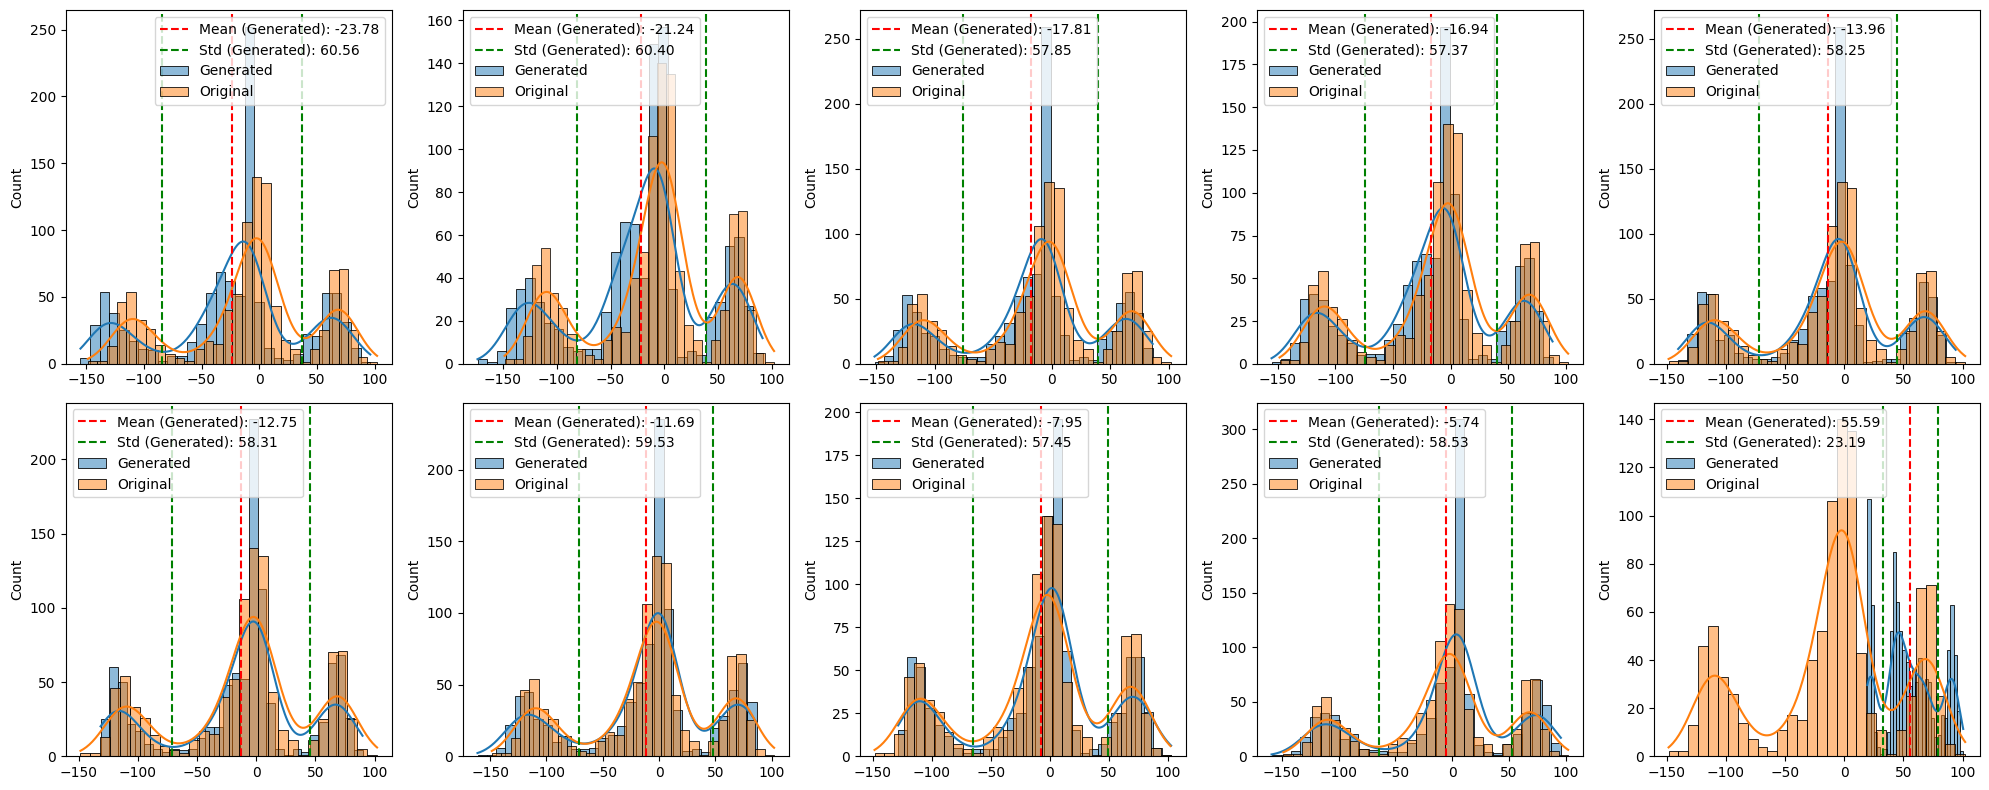

<Figure size 640x480 with 0 Axes>

In [247]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, alpha_mix in enumerate(np.linspace(0.05, 0.95, 10)):
    print(np.round(alpha_mix, 2))
    trainGmul(x_train, y_train, x_val, y_val, alpha_mix,False)
    ax = axes[i // 5, i % 5]
    qmodel = GNet0(input_dim, hidden_size=32, alpha=alpha_mix).cuda()
    qmodel.load_state_dict(torch.load("best_model.pth"))
    tr = scay5.inverse_transform((qmodel(torch.Tensor(sca_X_test_5[:,:-1]).cuda(), alpha_mix * torch.ones(X_test_5.shape[0], 1).cuda()).cuda()).cpu().detach().numpy())

    # 计算生成数据的均值和方差
    mean_generated = np.mean(tr)
    std_generated = np.std(tr)

    sns.histplot(tr, kde=True, bins=30, label='Generated', ax=ax)
    sns.histplot(X_test_5[:,-1], kde=True, bins=30, label='Original', ax=ax)

    # 添加生成数据的均值和方差线
    ax.axvline(mean_generated, color='r', linestyle='--', label=f'Mean (Generated): {mean_generated:.2f}')
    ax.axvline(mean_generated + std_generated, color='g', linestyle='--', label=f'Std (Generated): {std_generated:.2f}')
    ax.axvline(mean_generated - std_generated, color='g', linestyle='--')

    ax.legend()  # 添加图例

plt.tight_layout()
plt.show()
plt.savefig('generated0_alpha_mix.png')

In [249]:
import torchviz

qmodel = GNet_multihead_attention(input_dim, hidden_size=32, alpha=0.5).cuda()
x_sample = torch.Tensor(sca_X_test_5[:5, :-1]).cuda()
a_sample = 0.5 * torch.ones(5, 1).cuda()
torchviz.make_dot(qmodel(x_sample, a_sample), params=dict(qmodel.named_parameters())).render("network_structure", format="png")

'network_structure.png'

In [84]:
import torch
import torch.nn as nn
import torch.optim as optim
alpha = 0.5
# 1. 创建模型
class QuantileBackbone_withpenality(nn.Module):
    def __init__(self, input_dim, output_dim,alpha):
        super().__init__()
        self.alpha = alpha
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim + 1, 32),  # Concatenate quantile as an additional input feature
            nn.ReLU()
        )
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
        )
        
    def forward(self, x, quantile):   
        quantile = quantile.view(-1, 1)  # Ensure quantile is a column vector
        x = torch.cat((x, quantile), dim=1)
        x = self.linear_model1(x)
        x = self.linear_model2(x)
        return x

    
    def loss_fn(self, y_pred, y_true):
        return torch.mean(torch.max(self.alpha * (y_true - y_pred), (self.alpha - 1) * (y_true - y_pred))) 
    
    
    def loss_fn_2(self, y_pred, y_pred2, y_true):
        Out_G = y_pred
        Out_G2 = y_pred2
        fac = 2
        dist = torch.abs(Out_G - Out_G2)
        sd_y = torch.std(y_true).item()
        pen = torch.log((dist / sd_y) + 1.0 / fac)
        return pen.mean()


In [85]:
# 2. 准备数据（使用一些模拟数据作为示例）
input_dim = 2  # 假设输入特征维度为 10
output_dim = 1  # 假设输出为一个连续值（回归任务）

# 模拟数据
x_train = torch.tensor(sca_X_train_5[:,:-1]).cuda()
y_train = torch.tensor(sca_Y_train_5[:,-1].reshape(-1,1)).cuda()

# 3. 初始化模型、损失函数和优化器
qmodel = QuantileBackbone_withpenality(input_dim, output_dim,alpha=alpha).cuda()
optimizer = optim.Adam(qmodel.parameters(), lr=0.001)


num_epochs = 1000
for epoch in range(num_epochs):
    qmodel.train()  # 设置模型为训练模式
    optimizer.zero_grad()  # 清零梯度
    
    rand_aray = torch.rand_like(y_train).reshape(y_train.shape[0]).cuda()
    y_pred = qmodel(x_train,torch.tensor([alpha]*x_train.size(0)).cuda())
    y_pred2 = qmodel(x_train,rand_aray)
    loss = qmodel.loss_fn(y_pred, y_train)
    loss3 = qmodel.loss_fn_2(y_pred,y_pred2, y_train)
    loss-=loss3
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/1000], Loss: 1.0051
Epoch [20/1000], Loss: 0.9522
Epoch [30/1000], Loss: 0.8996
Epoch [40/1000], Loss: 0.8381
Epoch [50/1000], Loss: 0.7566
Epoch [60/1000], Loss: 0.6426
Epoch [70/1000], Loss: 0.5119
Epoch [80/1000], Loss: 0.3603
Epoch [90/1000], Loss: 0.1923
Epoch [100/1000], Loss: 0.0403
Epoch [110/1000], Loss: -0.0925
Epoch [120/1000], Loss: -0.2194
Epoch [130/1000], Loss: -0.3378
Epoch [140/1000], Loss: -0.4539
Epoch [150/1000], Loss: -0.5483
Epoch [160/1000], Loss: -0.6716
Epoch [170/1000], Loss: -0.7500
Epoch [180/1000], Loss: -0.8570
Epoch [190/1000], Loss: -0.9581
Epoch [200/1000], Loss: -1.0465
Epoch [210/1000], Loss: -1.1531
Epoch [220/1000], Loss: -1.2043
Epoch [230/1000], Loss: -1.3063
Epoch [240/1000], Loss: -1.3741
Epoch [250/1000], Loss: -1.4481
Epoch [260/1000], Loss: -1.5277
Epoch [270/1000], Loss: -1.5956
Epoch [280/1000], Loss: -1.6573
Epoch [290/1000], Loss: -1.7108
Epoch [300/1000], Loss: -1.7814
Epoch [310/1000], Loss: -1.8197
Epoch [320/1000], Loss: -1.

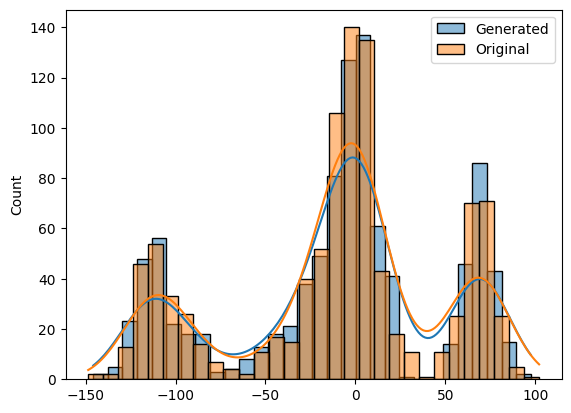

In [86]:
tr = scay5.inverse_transform(qmodel(torch.Tensor(sca_X_test_5[:,:-1]).cuda(), quantile=torch.tensor([alpha]*torch.tensor(sca_X_test_5[:,:-1]).size(0)).cuda()).cpu().detach().numpy())
sns.histplot(tr, kde=True, bins=30, label='Generated')
sns.histplot(X_test_5[:,-1], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例

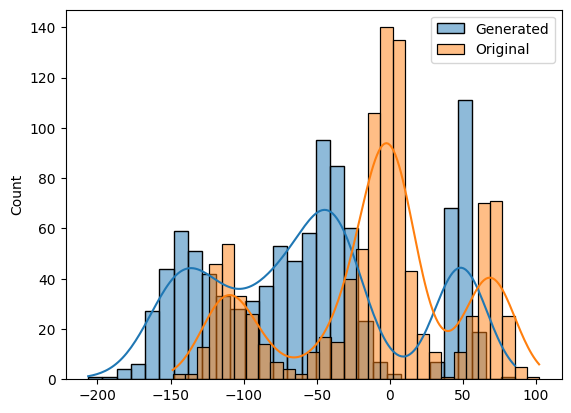

In [22]:
tr = scay5.inverse_transform(qmodel(torch.Tensor(sca_X_test_5[:,:-1]).cuda(), quantile=torch.tensor([alpha]*torch.tensor(sca_X_test_5[:,:-1]).size(0)).cuda()).cpu().detach().numpy())
sns.histplot(tr, kde=True, bins=30, label='Generated')
sns.histplot(X_test_5[:,-1], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例

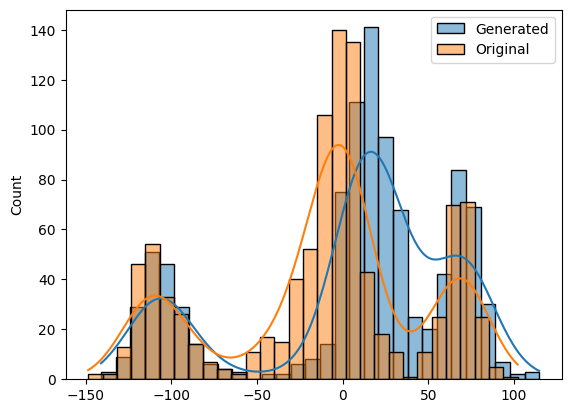

In [19]:
tr = scay5.inverse_transform(qmodel(torch.Tensor(sca_X_test_5[:,:-1]).cuda(), quantile=torch.tensor([alpha]*torch.tensor(sca_X_test_5[:,:-1]).size(0)).cuda()).cpu().detach().numpy())
sns.histplot(tr, kde=True, bins=30, label='Generated')
sns.histplot(X_test_5[:,-1], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
alpha = 0.95
# 1. 创建模型
class QuantileBackbone_withpenality(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, input_dim)  # 分位数的数量和输入数据长度一样
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim * 2, 32),
            nn.ReLU()
        )
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
        )
        
    def forward(self, x, quantile):   
        quantile = quantile.long()
        quantile_embedding = self.embedding(quantile)
        quantile_embedding = quantile_embedding.expand(x.size(0), -1)
        x = torch.cat((x, quantile_embedding), dim=1)
        x = self.linear_model1(x)
        x = self.linear_model2(x)
        return x

    
    def loss_fn(self, y_pred, y_true, alpha):
        return torch.mean(torch.max(alpha * (y_true - y_pred), (alpha - 1) * (y_true - y_pred))) 
    
    
    def loss_fn_2(self, y_pred, y_pred2, y_true):
        Out_G = y_pred
        Out_G2 = y_pred2
        fac = 1.5
        dist = torch.abs(Out_G - Out_G2)
        sd_y = torch.std(y_true).item()
        pen = torch.log((dist / sd_y) + 1.0 / fac)
        return pen.mean()

# 2. 准备数据（使用一些模拟数据作为示例）
input_dim = 2  # 假设输入特征维度为 10
output_dim = 1  # 假设输出为一个连续值（回归任务）

# 模拟数据
x_train = torch.tensor(sca_X_train_5[:,:-1]).cuda()
y_train = torch.tensor(sca_Y_train_5[:,-1].reshape(-1,1)).cuda()

# 3. 初始化模型、损失函数和优化器
qmodel = QuantileBackbone_withpenality(input_dim, output_dim).cuda()
optimizer = optim.Adam(qmodel.parameters(), lr=0.001)


num_epochs = 1000
for epoch in range(num_epochs):
    qmodel.train()  # 设置模型为训练模式
    optimizer.zero_grad()  # 清零梯度
    
    rand_aray = torch.rand_like(y_train).reshape(y_train.shape[0]).cuda()
    y_pred = qmodel(x_train,torch.tensor([alpha]*x_train.size(0)).cuda())
    y_pred2 = qmodel(x_train,rand_aray)
    loss = qmodel.loss_fn(y_pred, y_train, alpha)
    loss3 = qmodel.loss_fn_2(y_pred,y_pred2, y_train)
    loss-=loss3
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [10/1000], Loss: 0.6704
Epoch [20/1000], Loss: 0.6203
Epoch [30/1000], Loss: 0.5731
Epoch [40/1000], Loss: 0.5152
Epoch [50/1000], Loss: 0.4604
Epoch [60/1000], Loss: 0.4589
Epoch [70/1000], Loss: 0.4495
Epoch [80/1000], Loss: 0.4480
Epoch [90/1000], Loss: 0.4462
Epoch [100/1000], Loss: 0.4447
Epoch [110/1000], Loss: 0.4434
Epoch [120/1000], Loss: 0.4422
Epoch [130/1000], Loss: 0.4410
Epoch [140/1000], Loss: 0.4396
Epoch [150/1000], Loss: 0.4382
Epoch [160/1000], Loss: 0.4368
Epoch [170/1000], Loss: 0.4353
Epoch [180/1000], Loss: 0.4337
Epoch [190/1000], Loss: 0.4318
Epoch [200/1000], Loss: 0.4295
Epoch [210/1000], Loss: 0.4267
Epoch [220/1000], Loss: 0.4234
Epoch [230/1000], Loss: 0.4207
Epoch [240/1000], Loss: 0.4185
Epoch [250/1000], Loss: 0.4169
Epoch [260/1000], Loss: 0.4163
Epoch [270/1000], Loss: 0.4157
Epoch [280/1000], Loss: 0.4155
Epoch [290/1000], Loss: 0.4152
Epoch [300/1000], Loss: 0.4150
Epoch [310/1000], Loss: 0.4148
Epoch [320/1000], Loss: 0.4146
Epoch [330/1000],

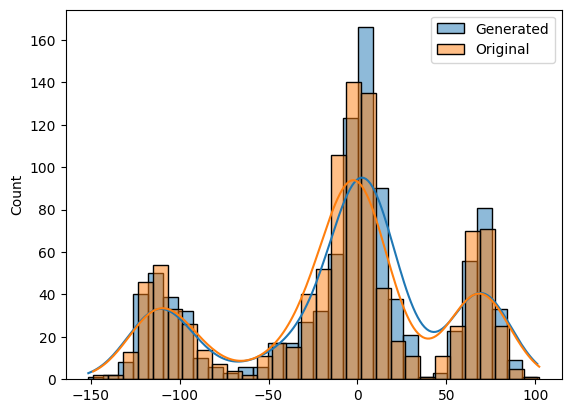

In [10]:
tr = scay5.inverse_transform(qmodel(torch.Tensor(sca_X_test_5[:,:-1]).cuda(), quantile=torch.tensor([alpha]*torch.tensor(sca_X_test_5[:,:-1]).size(0)).cuda()).cpu().detach().numpy())
sns.histplot(tr, kde=True, bins=30, label='Generated')
sns.histplot(X_test_5[:,-1], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例



0.1
epoch: 0, Train Loss: 0.4859, Val Loss: 0.4224
epoch: 0, find new best loss: Train Loss: 0.4224
----------
epoch: 1, find new best loss: Train Loss: 0.2050
----------
epoch: 2, find new best loss: Train Loss: 0.1901
----------
epoch: 3, find new best loss: Train Loss: 0.1489
----------
epoch: 5, find new best loss: Train Loss: 0.1392
----------
epoch: 6, find new best loss: Train Loss: 0.1273
----------
epoch: 8, find new best loss: Train Loss: 0.1233
----------
epoch: 9, find new best loss: Train Loss: 0.1160
----------
epoch: 10, find new best loss: Train Loss: 0.1056
----------
epoch: 14, find new best loss: Train Loss: 0.0950
----------
epoch: 16, find new best loss: Train Loss: 0.0910
----------
epoch: 18, find new best loss: Train Loss: 0.0905
----------
epoch: 19, find new best loss: Train Loss: 0.0846
----------
epoch: 20, Train Loss: 0.0902, Val Loss: 0.0966
epoch: 22, find new best loss: Train Loss: 0.0768
----------
epoch: 23, find new best loss: Train Loss: 0.0717
-----

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.4382, Val Loss: 0.3075
epoch: 0, find new best loss: Train Loss: 0.3075
----------
epoch: 1, find new best loss: Train Loss: 0.2025
----------
epoch: 2, find new best loss: Train Loss: 0.1902
----------
epoch: 3, find new best loss: Train Loss: 0.1429
----------
epoch: 4, find new best loss: Train Loss: 0.1426
----------
epoch: 5, find new best loss: Train Loss: 0.1266
----------
epoch: 6, find new best loss: Train Loss: 0.1226
----------
epoch: 8, find new best loss: Train Loss: 0.1059
----------
epoch: 10, find new best loss: Train Loss: 0.0897
----------
epoch: 13, find new best loss: Train Loss: 0.0887
----------
epoch: 14, find new best loss: Train Loss: 0.0864
----------
epoch: 19, find new best loss: Train Loss: 0.0789
----------
epoch: 20, Train Loss: 0.0803, Val Loss: 0.0638
epoch: 20, find new best loss: Train Loss: 0.0638
----------
epoch: 24, find new best loss: Train Loss: 0.0636
----------
epoch: 28, find new best loss: Train Loss: 0.0618
---------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.4904, Val Loss: 0.4362
epoch: 0, find new best loss: Train Loss: 0.4362
----------
epoch: 1, find new best loss: Train Loss: 0.2309
----------
epoch: 2, find new best loss: Train Loss: 0.1650
----------
epoch: 3, find new best loss: Train Loss: 0.1527
----------
epoch: 4, find new best loss: Train Loss: 0.1393
----------
epoch: 6, find new best loss: Train Loss: 0.1336
----------
epoch: 7, find new best loss: Train Loss: 0.1291
----------
epoch: 9, find new best loss: Train Loss: 0.1277
----------
epoch: 11, find new best loss: Train Loss: 0.1208
----------
epoch: 12, find new best loss: Train Loss: 0.1118
----------
epoch: 15, find new best loss: Train Loss: 0.1110
----------
epoch: 16, find new best loss: Train Loss: 0.1076
----------
epoch: 18, find new best loss: Train Loss: 0.0933
----------
epoch: 19, find new best loss: Train Loss: 0.0801
----------
epoch: 20, Train Loss: 0.1004, Val Loss: 0.0929
epoch: 23, find new best loss: Train Loss: 0.0770
---------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.4734, Val Loss: 0.3890
epoch: 0, find new best loss: Train Loss: 0.3890
----------
epoch: 1, find new best loss: Train Loss: 0.2127
----------
epoch: 2, find new best loss: Train Loss: 0.1815
----------
epoch: 3, find new best loss: Train Loss: 0.1499
----------
epoch: 4, find new best loss: Train Loss: 0.1361
----------
epoch: 5, find new best loss: Train Loss: 0.1349
----------
epoch: 6, find new best loss: Train Loss: 0.1300
----------
epoch: 8, find new best loss: Train Loss: 0.1254
----------
epoch: 9, find new best loss: Train Loss: 0.1223
----------
epoch: 10, find new best loss: Train Loss: 0.1084
----------
epoch: 13, find new best loss: Train Loss: 0.1052
----------
epoch: 16, find new best loss: Train Loss: 0.0981
----------
epoch: 17, find new best loss: Train Loss: 0.0948
----------
epoch: 18, find new best loss: Train Loss: 0.0837
----------
epoch: 20, Train Loss: 0.0973, Val Loss: 0.0922
epoch: 22, find new best loss: Train Loss: 0.0753
----------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.4630, Val Loss: 0.3673
epoch: 0, find new best loss: Train Loss: 0.3673
----------
epoch: 1, find new best loss: Train Loss: 0.1980
----------
epoch: 2, find new best loss: Train Loss: 0.1690
----------
epoch: 3, find new best loss: Train Loss: 0.1432
----------
epoch: 4, find new best loss: Train Loss: 0.1400
----------
epoch: 6, find new best loss: Train Loss: 0.1372
----------
epoch: 7, find new best loss: Train Loss: 0.1155
----------
epoch: 8, find new best loss: Train Loss: 0.1123
----------
epoch: 9, find new best loss: Train Loss: 0.0995
----------
epoch: 15, find new best loss: Train Loss: 0.0994
----------
epoch: 18, find new best loss: Train Loss: 0.0878
----------
epoch: 20, Train Loss: 0.1018, Val Loss: 0.1012
epoch: 25, find new best loss: Train Loss: 0.0862
----------
epoch: 26, find new best loss: Train Loss: 0.0718
----------
epoch: 33, find new best loss: Train Loss: 0.0708
----------
epoch: 36, find new best loss: Train Loss: 0.0684
----------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.4641, Val Loss: 0.4105
epoch: 0, find new best loss: Train Loss: 0.4105
----------
epoch: 1, find new best loss: Train Loss: 0.1827
----------
epoch: 2, find new best loss: Train Loss: 0.1576
----------
epoch: 3, find new best loss: Train Loss: 0.1545
----------
epoch: 4, find new best loss: Train Loss: 0.1320
----------
epoch: 6, find new best loss: Train Loss: 0.1164
----------
epoch: 8, find new best loss: Train Loss: 0.1109
----------
epoch: 10, find new best loss: Train Loss: 0.1031
----------
epoch: 11, find new best loss: Train Loss: 0.0984
----------
epoch: 12, find new best loss: Train Loss: 0.0923
----------
epoch: 16, find new best loss: Train Loss: 0.0786
----------
epoch: 20, Train Loss: 0.0884, Val Loss: 0.0783
epoch: 20, find new best loss: Train Loss: 0.0783
----------
epoch: 21, find new best loss: Train Loss: 0.0662
----------
Early stopping after 31 epochs
0.7000000000000001


c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.4593, Val Loss: 0.3799
epoch: 0, find new best loss: Train Loss: 0.3799
----------
epoch: 1, find new best loss: Train Loss: 0.2242
----------
epoch: 2, find new best loss: Train Loss: 0.1748
----------
epoch: 3, find new best loss: Train Loss: 0.1504
----------
epoch: 4, find new best loss: Train Loss: 0.1478
----------
epoch: 5, find new best loss: Train Loss: 0.1235
----------
epoch: 7, find new best loss: Train Loss: 0.1179
----------
epoch: 8, find new best loss: Train Loss: 0.1060
----------
epoch: 10, find new best loss: Train Loss: 0.0956
----------
epoch: 11, find new best loss: Train Loss: 0.0909
----------
epoch: 14, find new best loss: Train Loss: 0.0818
----------
epoch: 20, Train Loss: 0.0864, Val Loss: 0.1033
epoch: 22, find new best loss: Train Loss: 0.0705
----------
epoch: 29, find new best loss: Train Loss: 0.0700
----------
epoch: 31, find new best loss: Train Loss: 0.0675
----------
epoch: 36, find new best loss: Train Loss: 0.0656
---------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.4610, Val Loss: 0.3301
epoch: 0, find new best loss: Train Loss: 0.3301
----------
epoch: 1, find new best loss: Train Loss: 0.2058
----------
epoch: 2, find new best loss: Train Loss: 0.1882
----------
epoch: 3, find new best loss: Train Loss: 0.1413
----------
epoch: 4, find new best loss: Train Loss: 0.1307
----------
epoch: 5, find new best loss: Train Loss: 0.1254
----------
epoch: 7, find new best loss: Train Loss: 0.1189
----------
epoch: 10, find new best loss: Train Loss: 0.1029
----------
epoch: 12, find new best loss: Train Loss: 0.0998
----------
epoch: 13, find new best loss: Train Loss: 0.0958
----------
epoch: 14, find new best loss: Train Loss: 0.0931
----------
epoch: 16, find new best loss: Train Loss: 0.0849
----------
epoch: 17, find new best loss: Train Loss: 0.0829
----------
epoch: 19, find new best loss: Train Loss: 0.0771
----------
epoch: 20, Train Loss: 0.0859, Val Loss: 0.0828
epoch: 23, find new best loss: Train Loss: 0.0727
--------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.4483, Val Loss: 0.3737
epoch: 0, find new best loss: Train Loss: 0.3737
----------
epoch: 1, find new best loss: Train Loss: 0.2101
----------
epoch: 2, find new best loss: Train Loss: 0.1670
----------
epoch: 3, find new best loss: Train Loss: 0.1476
----------
epoch: 5, find new best loss: Train Loss: 0.1333
----------
epoch: 7, find new best loss: Train Loss: 0.1249
----------
epoch: 8, find new best loss: Train Loss: 0.1041
----------
epoch: 11, find new best loss: Train Loss: 0.1038
----------
epoch: 12, find new best loss: Train Loss: 0.0979
----------
epoch: 17, find new best loss: Train Loss: 0.0876
----------
epoch: 18, find new best loss: Train Loss: 0.0851
----------
epoch: 20, Train Loss: 0.0904, Val Loss: 0.0859
epoch: 25, find new best loss: Train Loss: 0.0831
----------
epoch: 27, find new best loss: Train Loss: 0.0800
----------
epoch: 28, find new best loss: Train Loss: 0.0627
----------
epoch: 36, find new best loss: Train Loss: 0.0556
--------

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


epoch: 0, Train Loss: 0.4336, Val Loss: 0.3250
epoch: 0, find new best loss: Train Loss: 0.3250
----------
epoch: 1, find new best loss: Train Loss: 0.2485
----------
epoch: 2, find new best loss: Train Loss: 0.1553
----------
epoch: 4, find new best loss: Train Loss: 0.1352
----------
epoch: 9, find new best loss: Train Loss: 0.1239
----------
epoch: 11, find new best loss: Train Loss: 0.1201
----------
epoch: 12, find new best loss: Train Loss: 0.1191
----------
epoch: 15, find new best loss: Train Loss: 0.0955
----------
epoch: 17, find new best loss: Train Loss: 0.0940
----------
epoch: 19, find new best loss: Train Loss: 0.0907
----------
epoch: 20, Train Loss: 0.0942, Val Loss: 0.0762
epoch: 20, find new best loss: Train Loss: 0.0762
----------
epoch: 26, find new best loss: Train Loss: 0.0736
----------
epoch: 27, find new best loss: Train Loss: 0.0659
----------
epoch: 31, find new best loss: Train Loss: 0.0572
----------
epoch: 40, Train Loss: 0.0761, Val Loss: 0.0786
Early st

c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


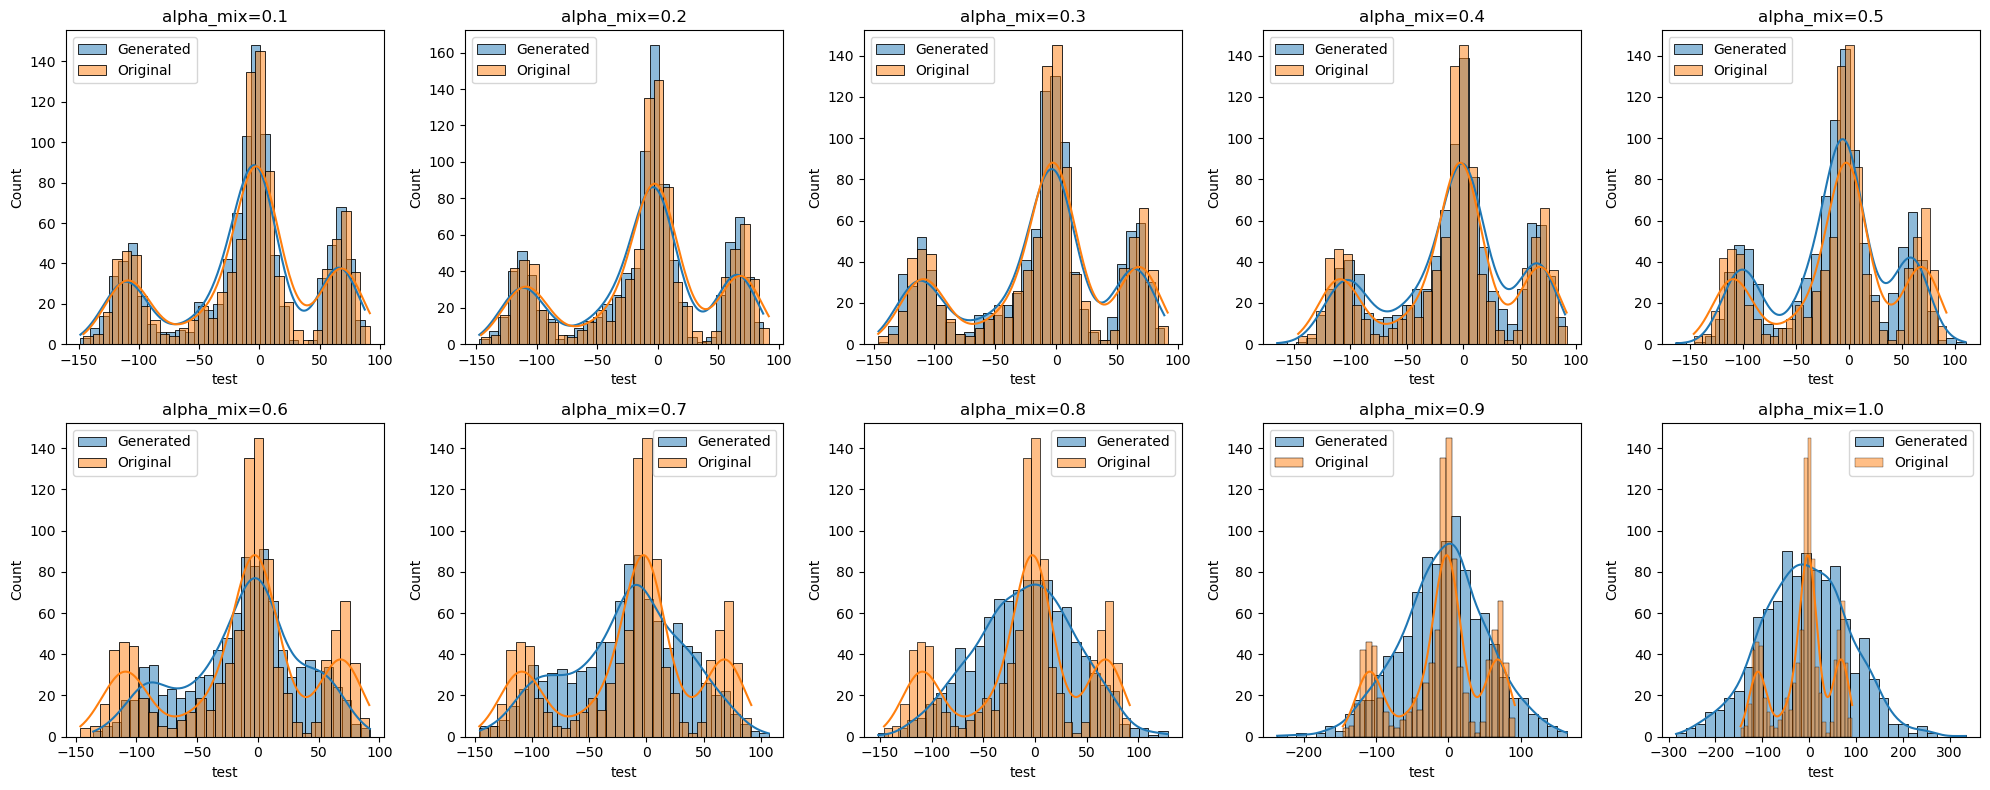

In [40]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, alpha_mix in enumerate(np.linspace(0.1, 1, 10)):
    print(alpha_mix)
    model = Model(device, beta_1, beta_T, T, targetdim, condim,alpha_mix=alpha_mix,iftrained=True,trainedmodel=qmodel)
    optimizer = torch.optim.Adam(list(model.backbone.parameters()) + list(model.quantile_backbone.parameters()), lr=1e-3)
    traincon_ddpm(model, optimizer, 100, 1, lambda1, alpha, sca_traindata_loader_5, sca_valdata_loader_5, 10)
    model.eval()
    diffusion = DiffusionProcess(beta_1, beta_T, T, model, device, 1, condim)
    sampling_number = sca_X_test_5.shape[0]
    only_final = True
    process = DiffusionProcess(beta_1, beta_T, T, model, device, (1,), torch.Tensor(sca_X_test_5[:,:-1]).cuda())
    sample = process.sampling(sampling_number, torch.Tensor(sca_X_test_5[:,:-1]).cuda(), only_final)
    trandatacvae = scay5.inverse_transform(sample.cpu().detach().numpy())
    ax = axes[i // 5, i % 5]
    sns.histplot(trandatacvae, kde=True, bins=30, label='Generated', ax=ax)
    sns.histplot(resultdata['test'], kde=True, bins=30, label='Original', ax=ax)
    ax.legend()
    ax.set_title(f'alpha_mix={alpha_mix:.1f}')

plt.tight_layout()
plt.savefig('generated_alpha_pretrain.png')
plt.show()

In [14]:
class Model(nn.Module):
    def __init__(self, trained_quantile, device, beta_1, beta_T, T, input_dim,con_dim,alpha_mix):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''
        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = con_Backbone(T, input_dim,con_dim)
        self.quantile_backbone = trained_quantile
        self.alpha_mix = alpha_mix  
        self.to(device = self.device)
        # for param in self.quantile_backbone.parameters():
        #     param.requires_grad = False
    def loss_fn(self, x, con_x, lambda1, alpha, idx=None, train_stage="joint"):
        '''
        Compute the loss for training.

        train_stage : "quantile" (only train quantile regression),
                    "diffusion" (only train diffusion),
                    "joint" (jointly train both).
        '''

        # 根据不同的训练阶段计算损失
        quantile_output,output, epsilon, alpha_bar = self.forward(x, con_x,  idx=idx, get_target=True)

        # 计算 quantile loss
        quantile_loss = self.quantile_backbone.loss_fn(quantile_output, x, alpha)

        # 计算 diffusion loss
        ddpm_loss = (output - epsilon).square().mean()

        # 根据 train_stage 决定冻结哪一部分网络的梯度
        if train_stage == "quantile":
            # 冻结 diffusion 部分
            for param in self.backbone.parameters():
                param.requires_grad = False
            for param in self.quantile_backbone.parameters():
                param.requires_grad = True
            return lambda1 * quantile_loss

        elif train_stage == "diffusion":
            # 冻结 quantile 部分
            for param in self.quantile_backbone.parameters():
                param.requires_grad = False
            for param in self.backbone.parameters():
                param.requires_grad = True
            return ddpm_loss

        elif train_stage == "joint":
            # 两部分都更新
            for param in self.quantile_backbone.parameters():
                param.requires_grad = True
            for param in self.backbone.parameters():
                param.requires_grad = True
            
            # 在最后一次计算损失时打印 quantile_output
            return lambda1 * quantile_loss + (1-lambda1) * ddpm_loss

        else:
            raise ValueError("Invalid train_stage. Choose from ['quantile', 'diffusion', 'joint'].")

    
    
    def forward(self, x,con_x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (epsilon prediction)

        '''
        quantile_output = self.quantile_backbone(torch.tensor(con_x).cuda())
        quantile_output_mixed = self.alpha_mix*quantile_output+(1-self.alpha_mix)*x
        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * quantile_output_mixed + torch.sqrt(1 - used_alpha_bars) * epsilon
            
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = quantile_output_mixed
            

            
        output = self.backbone(x_tilde,con_x, idx)
        
        return (quantile_output, output, epsilon, used_alpha_bars) if get_target else output
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, shape,con_x):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        shape         : data shape
        '''

        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.shape = shape
        
        self.diffusion_fn = diffusion_fn
        self.device = device

    
    def _one_diffusion_step(self, x,con_x):
        '''
        x   : perturbated data
        '''
        for idx in reversed(range(len(self.alpha_bars))):
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            sqrt_tilde_beta = torch.sqrt((1 - self.alpha_prev_bars[idx]) / (1 - self.alpha_bars[idx]) * self.betas[idx])
            predict_epsilon = self.diffusion_fn(x,con_x, idx)
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x - self.betas[idx] / torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon)
            x = mu_theta_xt + sqrt_tilde_beta * noise
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number,con_x, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        if self.shape[0]==1:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze().reshape(-1,1)
        else:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze()
        sampling_list = []
        
        final = None
        for idx, sample in enumerate(self._one_diffusion_step(sample,con_x)):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
scatter_range = [-10, 10]
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.2
batch_size =64

In [17]:
def traincon_ddpm(model,optimizer,num_epochs,targetdim,traindata_loader,valdata_loader,early_stopping):
    best_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(num_epochs):
        whole_loss = 0
        for i, batch in enumerate(traindata_loader):
            batch_size = batch.shape[0]
            if targetdim==1:
                batch = batch.cuda()
                y1 = batch[:,-1].reshape(-1,1).cuda()
                x1 = batch[:,:-1].cuda()
            else:
                batch = batch.cuda()
                y1 =  torch.Tensor(batch[:,-targetdim:]).cuda() 
                x1 = batch[:,:-targetdim].cuda()
            loss = model.loss_fn(y1,x1, lambda1=1.0, alpha=alpha, train_stage="quantile")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss = model.loss_fn(y1, x1, lambda1=0.0, alpha=alpha, train_stage="diffusion")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss = model.loss_fn(y1, x1, lambda1=0.5, alpha=alpha, train_stage="joint")
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.update(loss.item())
        val_loss = 0
        with torch.no_grad():
            for val_batch in valdata_loader:
                if targetdim==1:
                    batch = val_batch.cuda()
                    y1 = batch[:,-1].reshape(-1,1).cuda()
                    x1 = batch[:,:-1].cuda()
                else:
                    batch = val_batch.cuda()
                    y1 =  torch.Tensor(batch[:,-targetdim:]).cuda() 
                    x1 = batch[:,:-targetdim].cuda()
                val_loss+=model.loss_fn(y1,x1,lambda1=0.5, alpha=alpha, train_stage="joint")
            val_loss /= len(valdata_loader)
        if (epoch) % 20 == 0:
            print('epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, whole_loss/len(traindata_loader), val_loss.item()))
        loss_new = val_loss
        if loss_new < best_loss:
            best_loss = loss_new
            early_stopping_counter = 0
            print('epoch: {}, find new best loss: Train Loss: {:.4f}'.format(epoch,best_loss))
            print('-' * 10)
        else:
            early_stopping_counter += 1
        if early_stopping_counter == early_stopping:
            print("Early stopping after {} epochs".format(epoch))
            break
    

0.1


TypeError: linspace() received an invalid combination of arguments - got (start=torch.device, end=float, steps=float, ), but expected one of:
 * (Tensor start, Tensor end, int steps, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (Number start, Tensor end, int steps, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (Tensor start, Number end, int steps, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (Number start, Number end, int steps, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


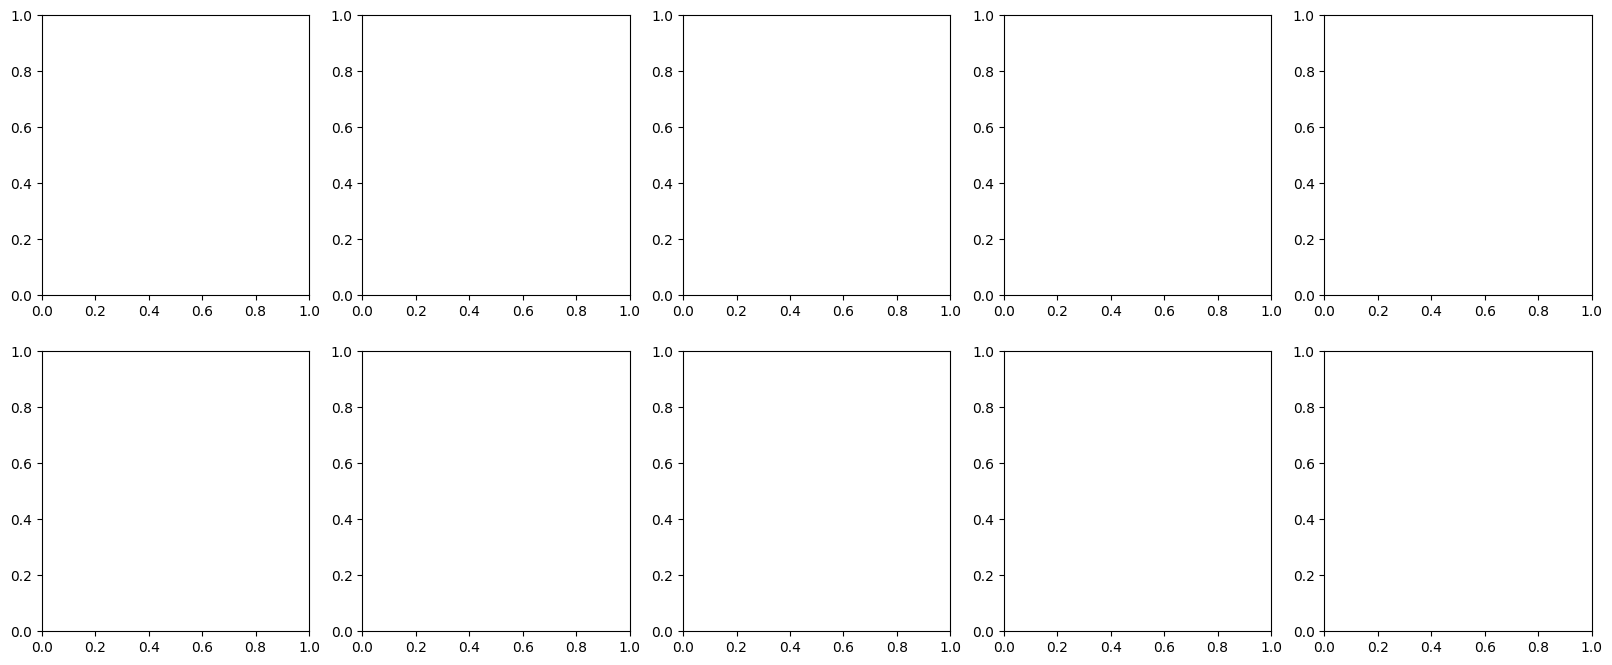

In [125]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, alpha_mix in enumerate(np.linspace(0.1, 1, 10)):
    print(alpha_mix)
    model = Model(qmodel, device, beta_1, beta_T, T, 1, condim, alpha_mix)
    optimizer = torch.optim.Adam(model.backbone.parameters(), lr=1e-3)
    traincon_ddpm(model, optimizer, 100, 1, sca_traindata_loader_5, sca_valdata_loader_5, 10)
    model.eval()
    diffusion = DiffusionProcess(beta_1, beta_T, T, model, device, 1, condim)
    sampling_number = sca_X_test_5.shape[0]
    only_final = True
    process = DiffusionProcess(beta_1, beta_T, T, model, device, (1,), torch.Tensor(sca_X_test_5[:,:-1]).cuda())
    sample = process.sampling(sampling_number, torch.Tensor(sca_X_test_5[:,:-1]).cuda(), only_final)
    trandatacvae = scay5.inverse_transform(sample.cpu().detach().numpy())
    ax = axes[i // 5, i % 5]
    sns.histplot(trandatacvae, kde=True, bins=30, label='Generated', ax=ax)
    sns.histplot(resultdata['test'], kde=True, bins=30, label='Original', ax=ax)
    ax.legend()
    ax.set_title(f'alpha_mix={alpha_mix:.1f}')

plt.tight_layout()
plt.savefig('generated_alpha_2.png')
plt.show()

C:\Users\miaoz\AppData\Local\Temp\ipykernel_12744\2847463790.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  quantile_output = self.quantile_backbone(torch.tensor(con_x).cuda())


epoch: 0, Train Loss: 0.0000, Val Loss: 0.1877
epoch: 0, find new best loss: Train Loss: 0.1877
----------
epoch: 1, find new best loss: Train Loss: 0.1652
----------
epoch: 2, find new best loss: Train Loss: 0.1299
----------
epoch: 3, find new best loss: Train Loss: 0.1078
----------
epoch: 9, find new best loss: Train Loss: 0.0790
----------
epoch: 11, find new best loss: Train Loss: 0.0752
----------
epoch: 16, find new best loss: Train Loss: 0.0653
----------
epoch: 20, Train Loss: 0.0000, Val Loss: 0.0835
Early stopping after 26 epochs


c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\miaoz\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


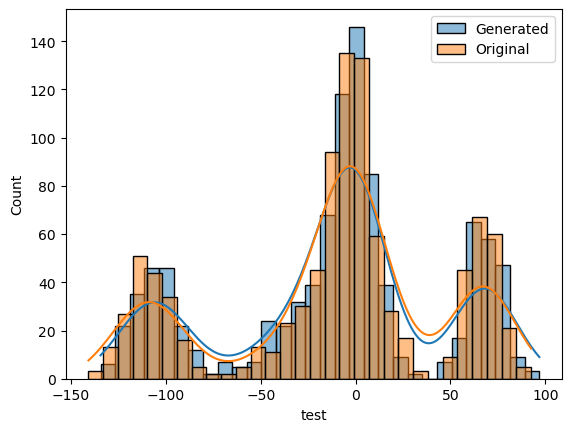

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

alpha_mix = 0.2
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
batch_size =64
beta_1 = 1e-4
beta_T = 0.02
T = 50
device = torch.device('cuda')
model = Model(qmodel,device, beta_1, beta_T, T, 1,condim,alpha_mix=alpha_mix)
optim = torch.optim.Adam(model.parameters(), lr = 0.005)
process = DiffusionProcess(beta_1, beta_T, T, model, device, 1,condim)
traincon_ddpm(model,optim,100,1,sca_traindata_loader_5,sca_valdata_loader_5,10)
sampling_number = sca_X_test_5.shape[0]
only_final = True
process = DiffusionProcess(beta_1, beta_T, T, model, device, (1,),torch.Tensor(sca_X_test_5[:,:-1]).cuda())
sample = process.sampling(sampling_number,torch.Tensor(sca_X_test_5[:,:-1]).cuda(),only_final)
trandatacvae = scay5.inverse_transform(sample.cpu().detach().numpy())
sns.histplot(trandatacvae, kde=True, bins=30, label='Generated')
sns.histplot(resultdata['test'], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例

In [99]:
class con_Backbone(nn.Module):
    def __init__(self, n_steps, input_dim = 1,con_dim=4):
        super().__init__()
        self.linear_model1 = nn.Sequential(
            nn.Linear(input_dim+con_dim, 32),
            nn.ReLU()
        )
        # Condition time t
        self.embedding_layer = nn.Embedding(n_steps, 32)
        
        self.linear_model2 = nn.Sequential(
            nn.Linear(32+con_dim, 32),
            nn.ReLU(),
            
            nn.Linear(32, 64),
            nn.ReLU(),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, input_dim),
        )
    def forward(self, x, con_x,idx):   
        x = torch.cat((x, con_x), dim=1) 
        x = torch.cat((self.linear_model1(x)+self.embedding_layer(idx),con_x),dim = 1)
        x = self.linear_model2(x)
        return x
class Model(nn.Module):
    def __init__(self, device, beta_1, beta_T, T, input_dim,con_dim):
        '''
        The epsilon predictor of diffusion process.

        beta_1    : beta_1 of diffusion process
        beta_T    : beta_T of diffusion process
        T         : Diffusion Steps
        input_dim : a dimension of data

        '''
        super().__init__()
        self.device = device
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.backbone = con_Backbone(T, input_dim,con_dim)
        
        self.to(device = self.device)

    def loss_fn(self, x,con_x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        output, epsilon, alpha_bar = self.forward(x,con_x, idx=idx, get_target=True)
        loss = (output - epsilon).square().mean()
        return loss

        
    def forward(self, x,con_x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (epsilon prediction)

        '''

        if idx == None:
            idx = torch.randint(0, len(self.alpha_bars), (x.size(0), )).to(device = self.device)
            used_alpha_bars = self.alpha_bars[idx][:, None]
            epsilon = torch.randn_like(x)
            x_tilde = torch.sqrt(used_alpha_bars) * x + torch.sqrt(1 - used_alpha_bars) * epsilon
            
        else:
            idx = torch.Tensor([idx for _ in range(x.size(0))]).to(device = self.device).long()
            x_tilde = x
            

            
        output = self.backbone(x_tilde,con_x, idx)
        
        return (output, epsilon, used_alpha_bars) if get_target else output
class DiffusionProcess():
    def __init__(self, beta_1, beta_T, T, diffusion_fn, device, shape,con_x):
        '''
        beta_1        : beta_1 of diffusion process
        beta_T        : beta_T of diffusion process
        T             : step of diffusion process
        diffusion_fn  : trained diffusion network
        shape         : data shape
        '''

        self.betas = torch.linspace(start = beta_1, end=beta_T, steps=T)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(1 - torch.linspace(start = beta_1, end=beta_T, steps=T), dim = 0).to(device = device)
        self.alpha_prev_bars = torch.cat([torch.Tensor([1]).to(device=device), self.alpha_bars[:-1]])
        self.shape = shape
        
        self.diffusion_fn = diffusion_fn
        self.device = device

    
    def _one_diffusion_step(self, x,con_x):
        '''
        x   : perturbated data
        '''
        for idx in reversed(range(len(self.alpha_bars))):
            noise = torch.zeros_like(x) if idx == 0 else torch.randn_like(x)
            sqrt_tilde_beta = torch.sqrt((1 - self.alpha_prev_bars[idx]) / (1 - self.alpha_bars[idx]) * self.betas[idx])
            predict_epsilon = self.diffusion_fn(x,con_x, idx)
            mu_theta_xt = torch.sqrt(1 / self.alphas[idx]) * (x - self.betas[idx] / torch.sqrt(1 - self.alpha_bars[idx]) * predict_epsilon)
            x = mu_theta_xt + sqrt_tilde_beta * noise
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number,con_x, only_final=False):
        '''
        sampling_number : a number of generation
        only_final      : If True, return is an only output of final schedule step 
        '''
        if self.shape[0]==1:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze().reshape(-1,1)
        else:
            sample = torch.randn([sampling_number,*self.shape]).to(device = self.device).squeeze()
        sampling_list = []
        
        final = None
        for idx, sample in enumerate(self._one_diffusion_step(sample,con_x)):
            final = sample
            if not only_final:
                sampling_list.append(final)

        return final if only_final else torch.stack(sampling_list)

class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
scatter_range = [-10, 10]
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
dist1 = (3, 1) # mean : (3, 3), std : 1
dist2 = (-3, 1) # mean : (-3, -3), std : 1
probability = 0.2
batch_size =64
def traincon_ddpm(model,optimizer,num_epochs,targetdim,traindata_loader,valdata_loader,early_stopping):
    best_loss = float('inf')
    early_stopping_counter = 0
    for epoch in range(num_epochs):
        whole_loss = 0
        for i, batch in enumerate(traindata_loader):
            batch_size = batch.shape[0]
            if targetdim==1:
                batch = batch.cuda()
                y1 = batch[:,-1].reshape(-1,1).cuda()
                x1 = batch[:,:-1].cuda()
            else:
                batch = batch.cuda()
                y1 =  torch.Tensor(batch[:,-targetdim:]).cuda() 
                x1 = batch[:,:-targetdim].cuda()
            loss = model.loss_fn(y1,x1)
            whole_loss+=loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.update(loss.item())
        val_loss = 0
        with torch.no_grad():
            for val_batch in valdata_loader:
                if targetdim==1:
                    batch = val_batch.cuda()
                    y1 = batch[:,-1].reshape(-1,1).cuda()
                    x1 = batch[:,:-1].cuda()
                else:
                    batch = val_batch.cuda()
                    y1 =  torch.Tensor(batch[:,-targetdim:]).cuda() 
                    x1 = batch[:,:-targetdim].cuda()
                val_loss+=model.loss_fn(y1,x1)
            val_loss /= len(valdata_loader)
        if (epoch) % 20 == 0:
            print('epoch: {}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, whole_loss/len(traindata_loader), val_loss.item()))
        loss_new = val_loss
        if loss_new < best_loss:
            best_loss = loss_new
            early_stopping_counter = 0
            print('epoch: {}, find new best loss: Train Loss: {:.4f}'.format(epoch,best_loss))
            print('-' * 10)
        else:
            early_stopping_counter += 1
        if early_stopping_counter == early_stopping:
            print("Early stopping after {} epochs".format(epoch))
            break
    

In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train_5, X_temp_5 = train_test_split(data, test_size=0.2, random_state=42)
X_val_5, X_test_5 = train_test_split(X_temp_5, test_size=0.5, random_state=42)
X_train_5[:,-1] = tr.reshape(-1)
X_val_5[:,-1] = tr1.reshape(-1)
X_train_5 = pd.DataFrame(X_train_5)
X_test_5 = pd.DataFrame(X_test_5)
X_val_5 = pd.DataFrame(X_val_5)
condim = X_train_5.shape[1]-1
train_data = X_train_5
val_data = X_val_5
test_data = X_test_5
X_train_5 = np.array(train_data, dtype=np.float32)
X_val_5 = np.array(val_data, dtype=np.float32)
X_test_5 = np.array(test_data, dtype=np.float32)
resultdata = pd.DataFrame()
# 设置 'Weekly_Sales' 列的值为 vaedata 中的 'Weekly_Sales' 列的值
resultdata['test'] = X_test_5[:,-1]
scatrain5 = StandardScaler()
sca_X_train_5 = scatrain5.fit_transform(X_train_5)
scaval5 = StandardScaler()
sca_X_val_5 = scaval5.fit_transform(X_val_5)
scay5 = StandardScaler()
sca_Y_train_5 = scay5.fit_transform(X_train_5[:,-1].reshape(-1,1))
scatest5 = StandardScaler()
sca_X_test_5 = scatest5.fit_transform(X_test_5)
sca_traindata_loader_5 = DataLoader(sca_X_train_5, batch_size=64, shuffle=True)
sca_valdata_loader_5 = DataLoader(sca_X_val_5, batch_size=64, shuffle=True)
scatter_range = [-10, 10]
total_iteration = 1000
current_iteration = 0
display_iteration = 200
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')
batch_size =64
beta_1 = 1e-4
beta_T = 0.02
T = 50
device = torch.device('cuda')
model = Model(device, beta_1, beta_T, T, 1,condim)
optim = torch.optim.Adam(model.parameters(), lr = 0.005)
process = DiffusionProcess(beta_1, beta_T, T, model, device, 1,condim)
traincon_ddpm(model,optim,100,1,sca_traindata_loader_5,sca_valdata_loader_5,30)

epoch: 0, Train Loss: 0.5596, Val Loss: 0.3396
epoch: 0, find new best loss: Train Loss: 0.3396
----------
epoch: 1, find new best loss: Train Loss: 0.1926
----------
epoch: 2, find new best loss: Train Loss: 0.1418
----------
epoch: 3, find new best loss: Train Loss: 0.1346
----------
epoch: 4, find new best loss: Train Loss: 0.1313
----------
epoch: 6, find new best loss: Train Loss: 0.1095
----------
epoch: 10, find new best loss: Train Loss: 0.0959
----------
epoch: 13, find new best loss: Train Loss: 0.0836
----------
epoch: 18, find new best loss: Train Loss: 0.0836
----------
epoch: 20, Train Loss: 0.0899, Val Loss: 0.0844
epoch: 24, find new best loss: Train Loss: 0.0805
----------
epoch: 26, find new best loss: Train Loss: 0.0603
----------
epoch: 38, find new best loss: Train Loss: 0.0590
----------
epoch: 40, Train Loss: 0.0679, Val Loss: 0.0832
epoch: 48, find new best loss: Train Loss: 0.0432
----------
epoch: 60, Train Loss: 0.0491, Val Loss: 0.0644
epoch: 67, find new be

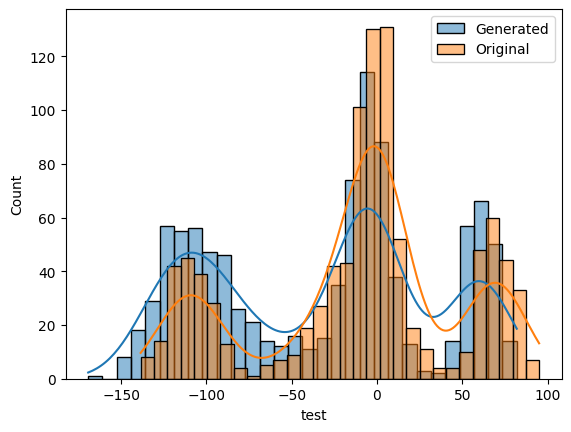

In [102]:
sampling_number = sca_X_test_5.shape[0]
only_final = True
process = DiffusionProcess(beta_1, beta_T, T, model, device, (1,),torch.Tensor(sca_X_test_5[:,:-1]).cuda())
sample = process.sampling(sampling_number,torch.Tensor(sca_X_test_5[:,:-1]).cuda(),only_final)
trandatacvae = scay5.inverse_transform(sample.cpu().detach().numpy())
sns.histplot(trandatacvae, kde=True, bins=30, label='Generated')
sns.histplot(resultdata['test'], kde=True, bins=30, label='Original')
plt.legend()  # 添加图例